In [2]:
import warnings
warnings.filterwarnings('ignore')
from typing import Final, Dict
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gym 
import gym_md
import shap
from md_shap import shappy, gen_analysis,gen_config
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, DQN
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
from util import debug_env
from itertools import repeat, chain

## Functions


In [14]:
obs_names = ['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP']
obs_names = ['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP']

revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

def plot_frequency(ax, x, y, xlabel, ylabel, title):
    sns.barplot(x=x, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

def qauntitative_results(explainer, shap_vals, data, df):
    print("----------------------------------------------------Generting quantitative results-------------------------------------------")
    # create shap value df
    df_shap = df[['curr_obs', 'action']]
    shap_valss = []
    policy_classes = ['killer','treasure','runner','potion']

    reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
    action_shap_vals=[]
    for i, row in df.iterrows():
        action = row['action']
        # get action taken index
        action_idx = policy_classes.index(action.lower())
        action_shap_vals.append(reshaped_shap_vals[i][action_idx])

    # Add shap_vals to the dataframe
    df_shap["shap_vals"] = pd.Series(action_shap_vals)
    df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

    # get the top five features for each state
    df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))

    # create rankings dataframe for the whole level by adding up the value counts
    df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
    df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')

    ax = sns.barplot(x=df_rankings.index, y=df_rankings.Importance_count)
    ax.set(xlabel='Features', ylabel='Times in Top 5 Most Important Features', title="Frequency of a feature being important \nin deciding the chosen action")

    melted_df = pd.melt(df_shap[['action','1st','2nd','3rd','4th','5th']], id_vars=['action'], value_vars=['1st', '2nd', '3rd', '4th', '5th'])
    df_action_rankings = pd.crosstab(index=melted_df['action'], columns=melted_df['value'])

    fig, ax = plt.subplots(1, len(df_action_rankings), figsize=(4 * len(df_action_rankings), 4))

    for i in range(len(df_action_rankings)):
        plot_frequency(ax[i], df_action_rankings.columns, df_action_rankings.iloc[i],
                    xlabel='Features', ylabel='Times in Top 5 Most Important Features',
                    title=f"Frequency of a feature being important \nwhen choosing the {df_action_rankings.index[i]} action")

    plt.tight_layout()
    plt.show() 
    return df_shap, df_rankings, df_action_rankings

def top_p_sampling(row, p):
    # convert values into probabilies 
    row = row.abs()
    row_sum = row.abs().sum()
    # Divide each value in the row by the sum to convert them into probabilities
    row = row.abs() / row_sum
    # Sort the row values in descending order
    sorted_row = row.sort_values(ascending=False)
    # Calculate cumulative probabilities
    cumulative_probs = sorted_row.cumsum()
    # Find indices where cumulative probability exceeds p
    indices = cumulative_probs > p

    # need to account for case where all values are true i.e where the first feature represents > than p
    if indices.isin([False]).any().any():
        selected_columns = sorted_row[~indices]
        #TODO limit to 5 or look into the p value
    else:
        selected_columns = sorted_row.iloc[[0]]
    
    # Select columns where the indices are False
    # selected_columns = sorted_row[~indices]
    
    return selected_columns

## Corralation Stuff

In [18]:
# def change_env_rew(env,reward_dict):
#     if config['reward_scheme'] =="treasure":
        
from md_shap import gen_data
from sklearn import preprocessing
from pandas import DataFrame
from scipy import stats


def get_reward_scheme(type):
    rewards  ={}
    if type == "treasure_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 1,
            "TREASURE":10,
            "POTION": 2,
            "DEAD": -20
        }
        return rewards
    elif type == "treasure_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 1,
            "TREASURE":20,
            "POTION": 1,
            "DEAD": -10
        }
        return rewards
    elif type == "treasure":
        rewards = {
            "TURN": 2,  #0.2, #2
            "EXIT": 10, #-1, #-10
            "KILL": 0, #-1.5, # -25
            "TREASURE":50, #2.5, # 50
            "POTION": 0, #-1.5, # -25
            "DEAD": -250, #-10 # 250
        }
        return rewards
    elif type == "killer_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 10,
            "TREASURE":1,
            "POTION": 9,
            "DEAD": -30
        }
        return rewards
    elif type == "killer_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 20,
            "TREASURE":1,
            "POTION": 2,
            "DEAD": -10
        }
        return rewards
    elif type == "killer":
        rewards = {
            "TURN": 2, #0.2,
            "EXIT": 10, # -1,
            "KILL": 50, #2.5,
            "TREASURE": 0, #-1.5,
            "POTION": 0, #-1.5,
            "DEAD": -250 #-10
        }
        return rewards
    elif type == "runner_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 15,
            "KILL": 1,
            "TREASURE":2,
            "POTION": 3,
            "DEAD": -10
        }
        return rewards
    elif type == "runner_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 30,
            "KILL": 1,
            "TREASURE":1,
            "POTION": 1,
            "DEAD": -5
        }
        return rewards
    elif type == "runner":
        rewards = {
            "TURN": 2, #0.2,
            "EXIT": 50, #2.5,
            "KILL": 0, #-1.5,
            "TREASURE": 0, #-1.5,
            "POTION": 0, # -1.5,
            "DEAD": -250, #-10
        }
        return rewards
    elif type == "clearer_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 15,
            "TREASURE":18,
            "POTION": 20,
            "DEAD": -15
        }
        return rewards
    elif type == "clearer_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 18,
            "TREASURE":20,
            "POTION": 20,
            "DEAD": -5
        }
        return rewards
    elif type == "potion":
        rewards = {
            "TURN": 2, #0.2,
            "EXIT": 10, #-1,
            "KILL": 0, #-1.5,
            "TREASURE": 0, #-1.5,
            "POTION": 50, #2.5,
            "DEAD": -250, #-10
        }
        return rewards
    elif type == "switch":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 10,
            "TREASURE":10,
            "POTION": 10,
            "DEAD": -25
        }
        return rewards
    elif type == "hard":
        rewards= {
            "TURN": 1,
            "EXIT": 20,
            "KILL": 4,
            "TREASURE": 3,
            "POTION": 1,
            "DEAD": -20
        }
        return rewards
    else :
        return 

def get_imporance_weights(reward_scheme):

    rewards = get_reward_scheme(reward_scheme)
    total_rewards = rewards['EXIT'] + rewards['TREASURE'] +rewards['KILL'] +rewards['POTION'] #+ rewards['DEAD']
    importance_wights = {
        'DE': (0.5*rewards['EXIT'])/total_rewards,
        "SDE": (0.5*rewards['EXIT'])/total_rewards,
        "DT": (0.5*rewards['TREASURE'])/total_rewards,
        "SDT": (0.5*rewards['TREASURE'])/total_rewards,
        "DM": (rewards["KILL"])/total_rewards,#(rewards["KILL"]+ 0.25*rewards["DEAD"])/total_rewards, #add DEAD
        "DP": (0.33*rewards["POTION"])/total_rewards,#(0.33*rewards["POTION"]+0.25*rewards["DEAD"])/total_rewards,
        "SDP": (0.33*rewards["POTION"])/total_rewards,#(0.33*rewards["POTION"]+0.25*rewards["DEAD"])/total_rewards,
        "HP": (0.33*rewards["POTION"])/total_rewards,#(0.33*rewards["POTION"]+0.25*rewards["DEAD"])/total_rewards,
    }
    return importance_wights

def get_info(env,config)->Dict:
    env_info ={}
    env_info = env.env
    return env_info

default_config= {
    'lvl':"hard",
    "play_style":"hard",
    "reward_scheme":"hard",
    "action_type": "policy",
    "action_space_type": "discrete",
    "obs_type": "distance",
    "base_path":  "./play_style_models/base/", 
    "exp_type":  "./play_style_models/base/", 
    "learning_algo":"PPO",
}

groups_by_reward={
    "Exit": ["DE","SDE"],
    "Treasure": ["DT","SDT"],
    "Kill":["DM"],
    "Potion":["SDP","DP"],
    "HP": ["HP"]
}

def outlier_removal(df:DataFrame):
    return df[(np.abs(stats.zscore(df)) < 2.75).all(axis=1)]

def groupwise_scale(df:DataFrame, group_column, numeric_column)->DataFrame:
    # Initialize StandardScaler
    # Group by the categorical column
    grouped = df.groupby(group_column)
    #remove otliers before scalling
    # Normalize the numeric column within each group
    df[numeric_column] = grouped[numeric_column].transform(lambda x: (x - x.min())/ (x.max() - x.min()))

    return df

def groupwise_normalize(df:DataFrame, group_column, numeric_column)->DataFrame:
    # Initialize StandardScaler
    # Group by the categorical column
    grouped = df.groupby(group_column)
    # Normalize the numeric column within each group
    df[numeric_column + '_normalized'] = grouped[numeric_column].transform(lambda x: (x - x.mean()) / x.std())
    return df

lvl_list =[
    # "hard",
    # "check_1",
    # "holmgard_0",
    "holmgard_1",
    "holmgard_2",
    "holmgard_3",
    "holmgard_4",
    "holmgard_5",
    "holmgard_6",
    "holmgard_7",
    # # "holmgard_8",
    "holmgard_9",
]

configs = gen_config(lvl ="hard",algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")

env = gym.make('md-switch-hard-v0', config= default_config)
rewards = get_reward_scheme(default_config['play_style'])   
env.change_reward_values(rewards)
normalizer = preprocessing.MinMaxScaler()

def gen_corr_results(lvl_list):
    # debug_env(env)

    #for every level in the level list:

    df_list = []
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            #generate data for that level
            explainer, shap_vals,data,df = shappy(config)
            # data = gen_data(config[1])
            # df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])

            df_shap = df[['level','play_style','curr_obs', 'action']]
            shap_valss = []
            policy_classes = ['killer','treasure','runner','potion']

            reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
            action_shap_vals=[]
            for i, row in df.iterrows():
                action = row['action']
                # get action taken index
                action_idx = policy_classes.index(action.lower())
                action_shap_vals.append(reshaped_shap_vals[i][action_idx])

            # Add shap_vals to the dataframe
            df_shap["shap_vals"] = pd.Series(action_shap_vals)
            df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

            # get the top five features for each state
            df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))
            
            # create rankings dataframe for the whole level by adding up the value counts
            df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
            df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')
            imp_w = get_imporance_weights(df_shap['play_style'].unique()[0])
            df_rankings['wieghts'] = df_rankings.index.map(imp_w)
            # df_rankings =df_rankings.T
            #TODO look into merging lvl and reward_scheme to help with groupwise normalization
            df_shap['grouping'] = df_shap["level"].astype(str)+"_"+df_shap["play_style"]
            df_rankings['level'] = df_shap['grouping'].unique()[0]

            df_list.append(df_rankings)
            # df_rankings

            # print(imp_w)
            # print(df_rankings)
    merged_df = pd.concat(df_list)
    # merged_df['wieghts'] = np.log(merged_df['wieghts'])
    # merged_df['Importance_count'] = np.log(merged_df['Importance_count'])

    # normalizer = preprocessing.StandardScaler()
    print(merged_df[["Importance_count","wieghts"]])
    # merged_df["wieghts"] = merged_df['wieghts'].replace(0.0 , 0.001)
    # normalizer = preprocessing.MinMaxScaler()


    # scaled = normalizer.fit_transform(merged_df[["Importance_count","wieghts"]].values)
    # merged_df["Importance_count"] = scaled[:,0]
    # merged_df["wieghts"] = scaled[:,1]
    merged_df['wieghts'] = np.log2(merged_df['wieghts'])
    merged_df['Importance_count'] = np.log2(merged_df['Importance_count'])
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df.dropna(subset=["Importance_count", "wieghts"], how="all", inplace=True)
    ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts')
    # plt.plot(merged_df['Importance_count'].values.T,reg.predict(merged_df['Importance_count'].values.T),ax=ax)
    sns.lmplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts',robust=True)
    return merged_df, df_list, df_shap
    

# df, df_list, df_shap =gen_corr_results(lvl_list=lvl_list)
# sns.scatterplot(data =df_rankings, x = 'wieghts',y ="Importance_count",hue=df_rankings.index)
def corralation_results(lvl_list,p = 0.97):
    #for every level in the level list:

    df_list = []
    df_shap_list= []
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            #generate data for that level
            explainer, shap_vals,data,df = shappy(config)
            # data = gen_data(config[1])
            # df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])

            df_shap = df[['level','play_style','curr_obs', 'action']]
            shap_valss = []
            policy_classes = ['killer','treasure','runner','potion']

            reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
            action_shap_vals=[]
            for i, row in df.iterrows():
                action = row['action']
                # get action taken index
                action_idx = policy_classes.index(action.lower())
                action_shap_vals.append(reshaped_shap_vals[i][action_idx])

            # Add shap_vals to the dataframe
            df_shap["shap_vals"] = pd.Series(action_shap_vals)
            df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

            # get the top five features for each state
            df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: top_p_sampling(x,p).index.tolist(), axis=1).tolist()))
            

            # create rankings dataframe for the whole level by adding up the value counts
            df_rankings = df_shap.drop(['level', 'play_style', 'curr_obs', 'action', 'shap_vals', 'DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP'],axis=1).apply(pd.Series.value_counts).sum(axis=1)
            df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')
            imp_w = get_imporance_weights(df_shap['play_style'].unique()[0])
            df_rankings['wieghts'] = df_rankings.index.map(imp_w)
            # df_rankings =df_rankings.T
            #TODO look into merging lvl and reward_scheme to help with groupwise normalization
            df_shap['grouping'] = df_shap["level"].astype(str)+"_"+df_shap["play_style"]
            df_rankings['level'] = df_shap['grouping'].unique()[0]

            df_list.append(df_rankings)
            df_shap_list.append(df_shap)

    merged_df = pd.concat(df_list)
    return merged_df,df_list,df_shap_list

# df, df_list, df_shap =corralation_results(lvl_list=lvl_list)
# df, df_list, df_shap =gen_corr_results(lvl_list)

{'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'action_type': 'policy', 'action_space_type': 'discrete', 'obs_type': 'distance', 'base_path': './play_style_models/base/', 'exp_type': './play_style_models/base/', 'learning_algo': 'PPO'}


In [19]:
df, df_list, df_shap_list =corralation_results(lvl_list=lvl_list)

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_1', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-holmgard_1_switch_switch_switch_analysis_PPO
action
TREASURE    161
KILLER       60
RUNNER       59
Name: count, dtype: int64
----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'holmgard_1', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-holmgard_1_hard_hard_switch_analysis_PPO
action
RUNNER    160
Name: count, dtype: int64
----------Perfroming Shapley Analy

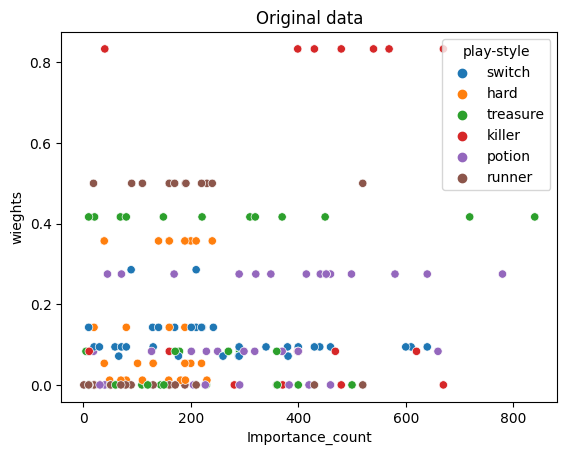

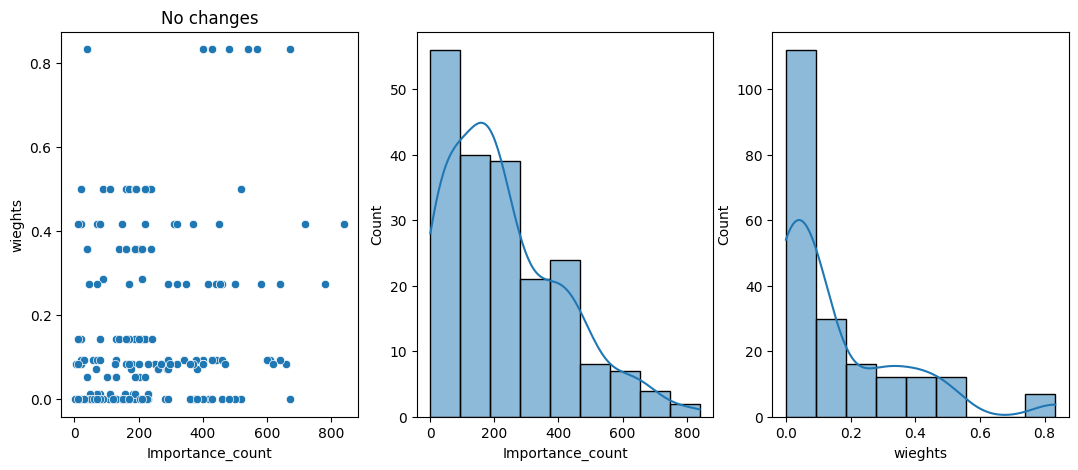

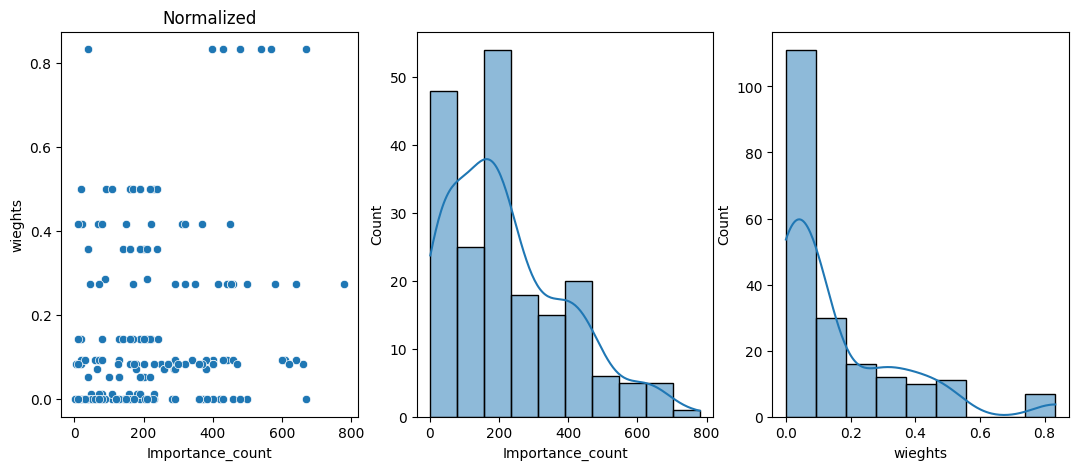

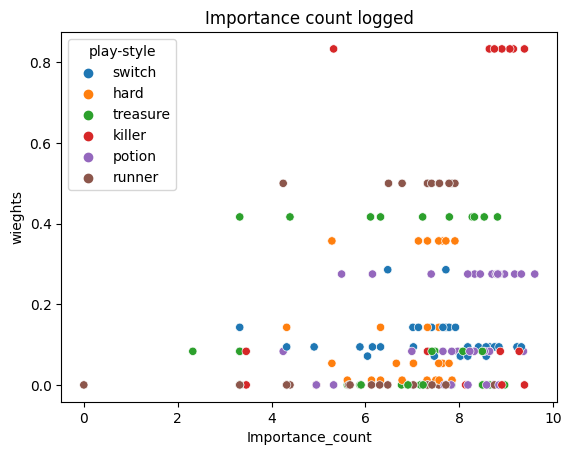

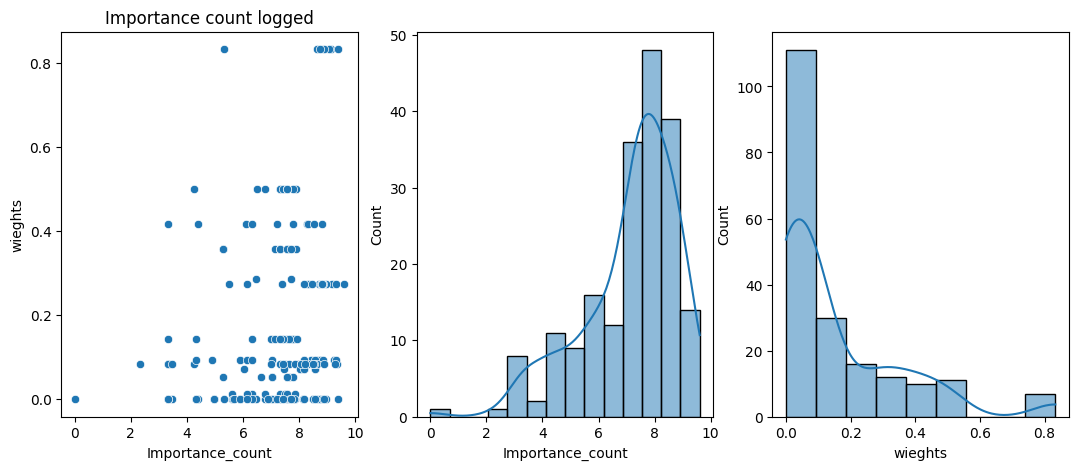

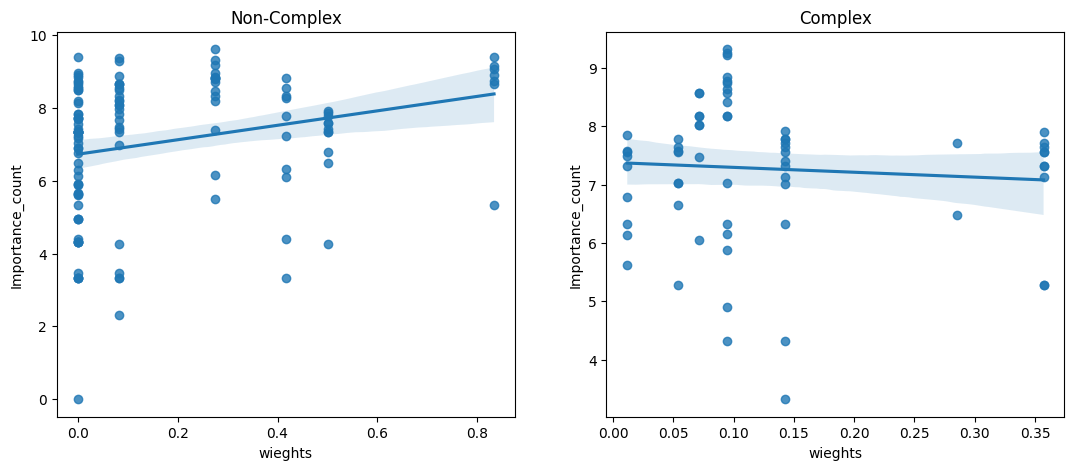

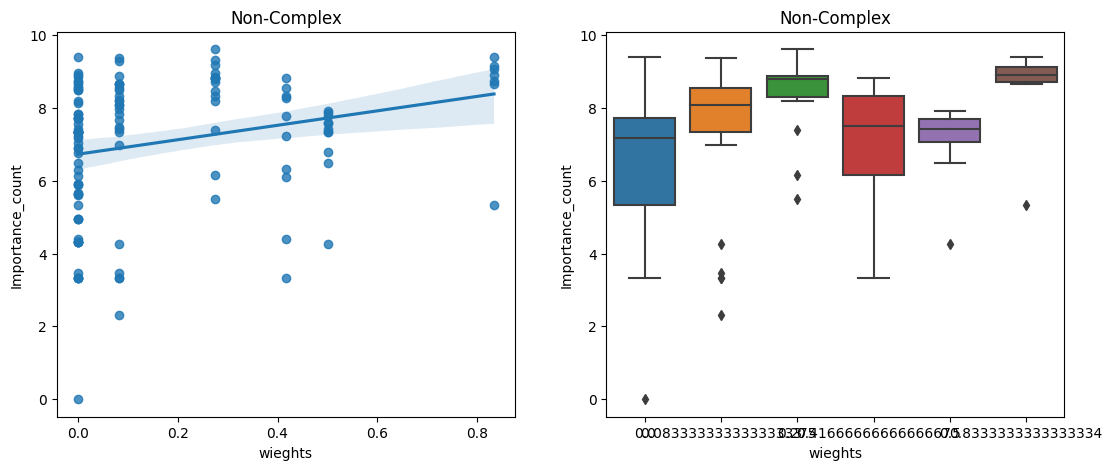

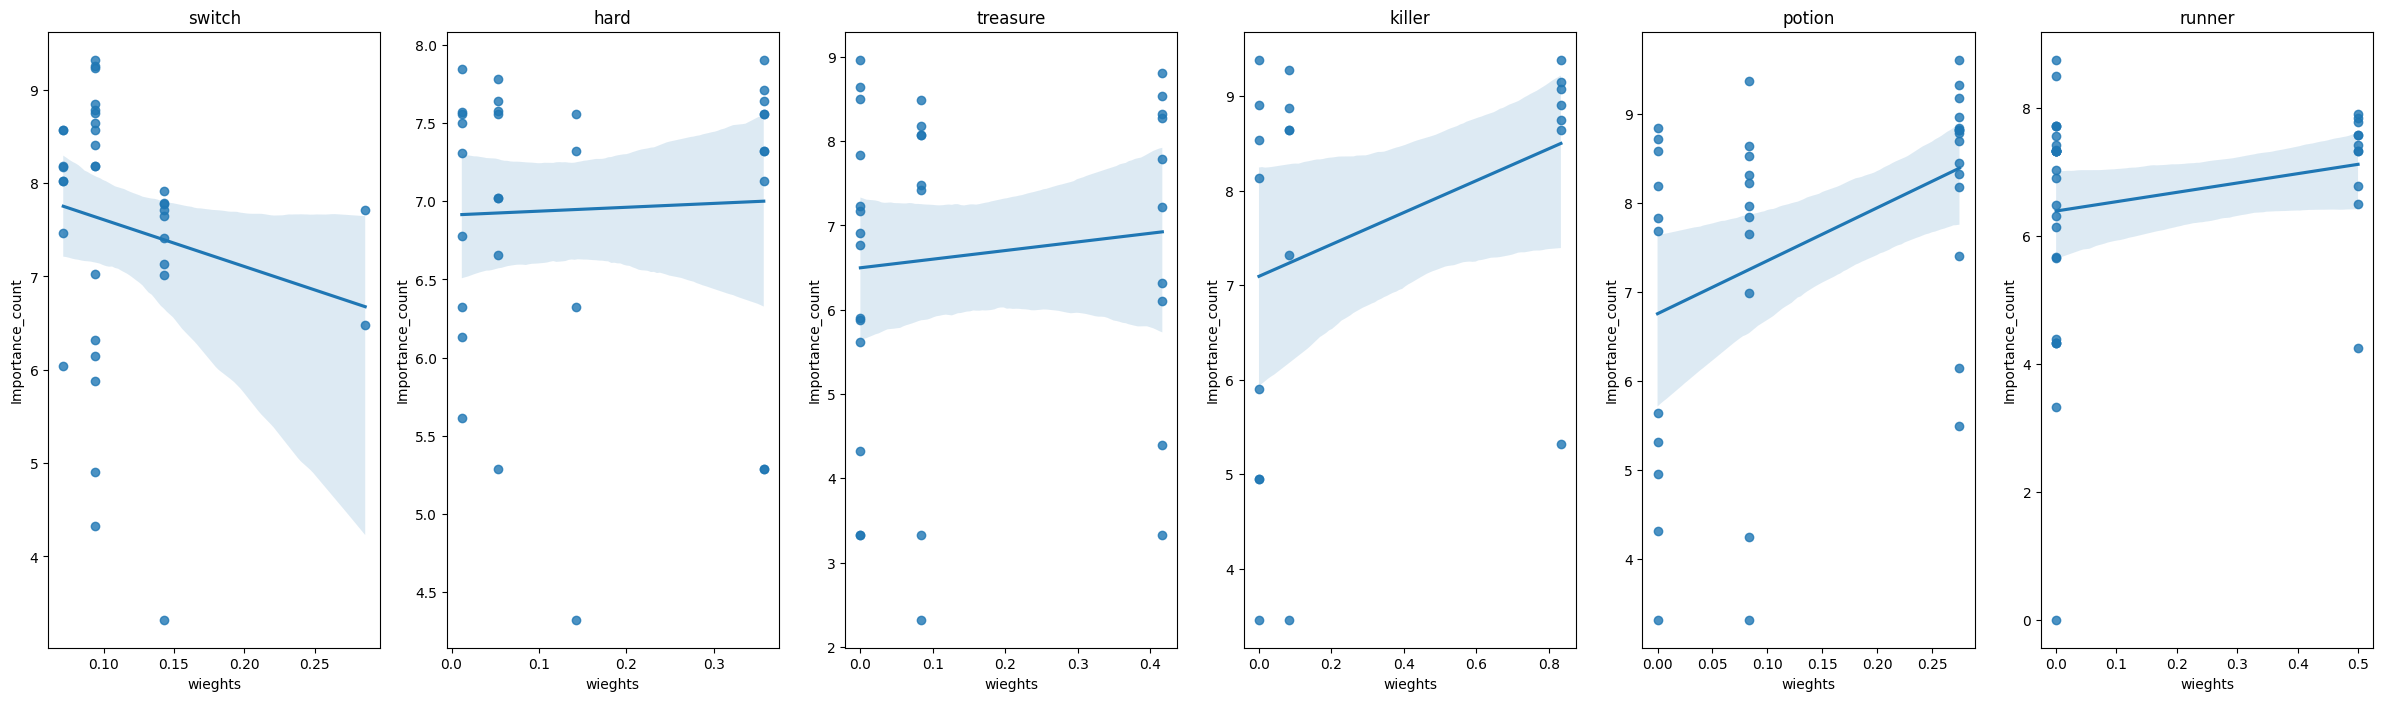

Kendall's Tau Correlation: 0.23421975836991363, P-value: 0.0004024976372457078
Spearman's Rank Correlation: 0.31361483695642767, P-value: 0.9998601061592486


In [71]:
#create single df
merged_df = pd.concat(df_list,ignore_index=True)
# merged_df.reset_index(drop=True)
merged_df["play-style"] = merged_df['level'].str.split('_').str[-1]
# print(merged_df[merged_df['Importance_count'] == 0])
# print(merged_df.describe())

ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',hue="play-style").set_title("Original data")
plt.show()

ig, axs = plt.subplots(nrows=1,ncols=3,figsize=(13,5))

sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=axs[0]).set_title("No changes")
sns.histplot(data=merged_df, x = 'Importance_count',ax=axs[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=axs[2],kde=True)
plt.show()
#remove outliers
merged_df = merged_df[merged_df.groupby(['play-style'])['Importance_count'].transform(stats.zscore).abs() < 2.5]

non_complex_df = merged_df[(merged_df['play-style']!= 'switch') & (merged_df['play-style']!= 'hard')]

#normalize data
# merged_df = groupwise_normalize(df=merged_df, group_column='level', numeric_column='Importance_count')
# merged_df = groupwise_normalize(df=merged_df, group_column='level', numeric_column='wieghts')
# scale data
# merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='Importance_count')
# merged_df = groupwise_scale(df=merged_df, group_column='play-style', numeric_column='wieghts')


ig, axs = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=axs[0]).set_title("Normalized")
sns.histplot(data=merged_df, x = 'Importance_count',ax=axs[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=axs[2],kde=True)
plt.show()

#log data
merged_df['Importance_count'] = np.log2(merged_df['Importance_count'])
# merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='Importance_count')

ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',hue="play-style").set_title("Importance count logged")
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=["Importance_count", "wieghts"], how="all", inplace=True)
plt.show()
# merged_df.reset_index(drop=True)
# print(merged_df)

ig, axs = plt.subplots(nrows=1,ncols=3,figsize=(13,5))

sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=axs[0]).set_title("Importance count logged")
sns.histplot(data=merged_df, x = 'Importance_count',ax=axs[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=axs[2],kde=True)
plt.show()

non_complex_df = merged_df[(merged_df['play-style']!= 'switch') & (merged_df['play-style']!= 'hard')]
complex_df = merged_df[(merged_df['play-style'] =='switch') | (merged_df['play-style']== 'hard')]

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5))
sns.regplot(data=non_complex_df[['Importance_count','wieghts']], y = 'Importance_count', x= 'wieghts', ax=ax[0]).set_title('Non-Complex')
sns.regplot(data=complex_df[['Importance_count','wieghts']], y = 'Importance_count', x= 'wieghts',ax=ax[1]).set_title('Complex')
plt.show()
# sns.residplot(data=non_complex_df[['Importance_count','wieghts']], y = 'Importance_count', x= 'wieghts',ax=ax[1]).set_title('Residuals')
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5))
sns.regplot(data=non_complex_df[['Importance_count','wieghts']], y = 'Importance_count', x= 'wieghts', ax=ax[0]).set_title('Non-Complex')
sns.boxplot(data=non_complex_df[['Importance_count','wieghts']], y = 'Importance_count', x= 'wieghts',ax=ax[1]).set_title('Non-Complex')
plt.show()

ig, ax = plt.subplots(1,len(merged_df['play-style'].unique()),figsize=(30,8))
for i , play_style in enumerate(merged_df['play-style'].unique()):
        # play_style_df = merged_df.where(merged_df['play-style']==play_style)
        # play_style_df = outlier_removal(play_style_df["Importance_count"])
        sns.regplot(y = "Importance_count", x = 'wieghts', data= merged_df.where(merged_df['play-style']==play_style), ax = ax[i]).set(title =play_style)

plt.show()

kendall_tau, p_value_tau = stats.kendalltau(y= non_complex_df['wieghts'], x= non_complex_df["Importance_count"])
print(f"Kendall's Tau Correlation: {kendall_tau}, P-value: {p_value_tau}")

# Calculate Spearman's rank correlation
spearman_corr, p_value_spearman = stats.spearmanr(non_complex_df['wieghts'], non_complex_df["Importance_count"], alternative='less')
print(f"Spearman's Rank Correlation: {spearman_corr}, P-value: {p_value_spearman}")


# show scores

     Importance_count   wieghts
SDP              59.0  0.094286
SDT             221.0  0.142857
DM               80.0  0.142857
DP               80.0  0.011786
DT              101.0  0.053571
..                ...       ...
DP               70.0  0.000000
SDT             171.0  0.000000
SDE             190.0  0.500000
DE              191.0  0.500000
SDP             210.0  0.000000

[1058 rows x 2 columns]
       Importance_count     wieghts
count       1058.000000  198.000000
mean          41.668242    0.156940
std          115.989889    0.201329
min            0.000000    0.000000
25%            0.000000    0.000000
50%            0.000000    0.083333
75%            0.000000    0.275000
max          840.000000    0.833333
     Importance_count  wieghts              level play-style
0                 0.0      NaN  holmgard_5_switch     switch
258               0.0      NaN  holmgard_5_switch     switch
257               0.0      NaN  holmgard_5_switch     switch
256               0.0  

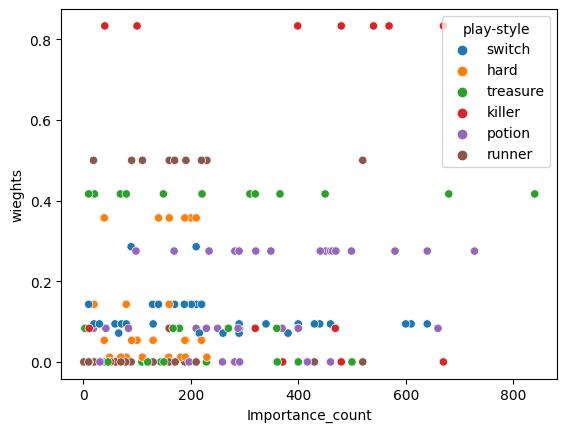

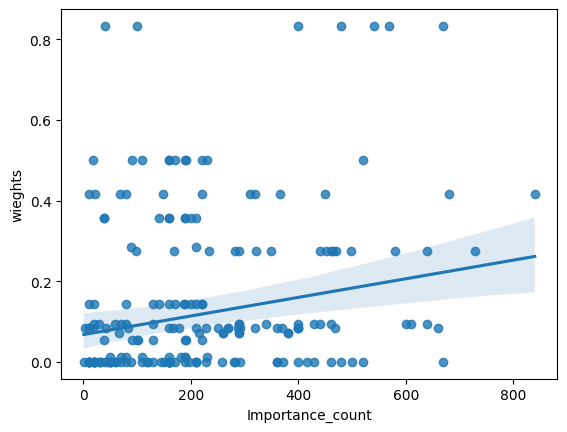

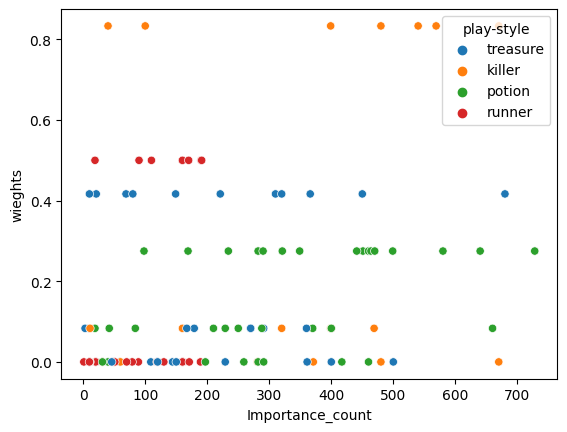

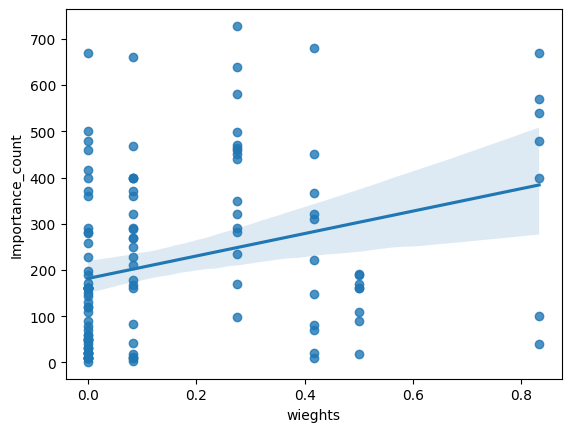

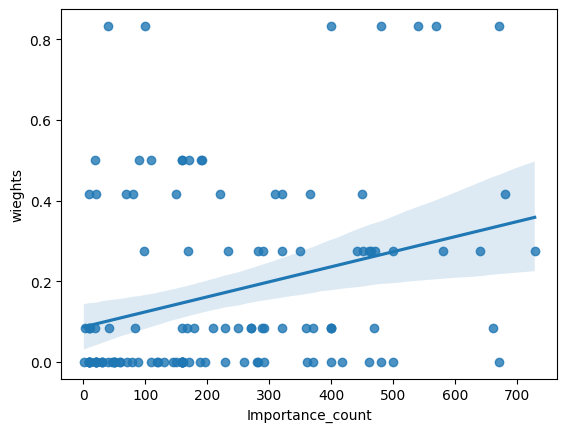

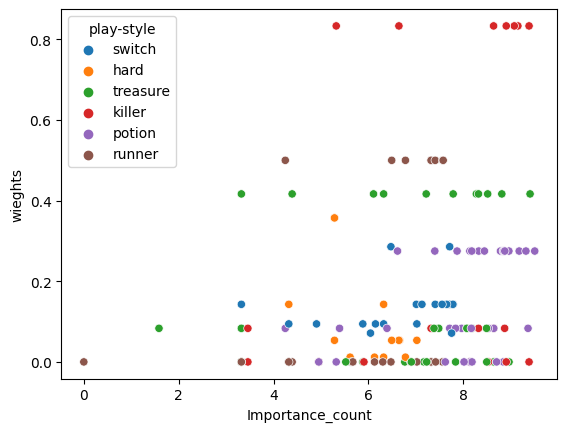

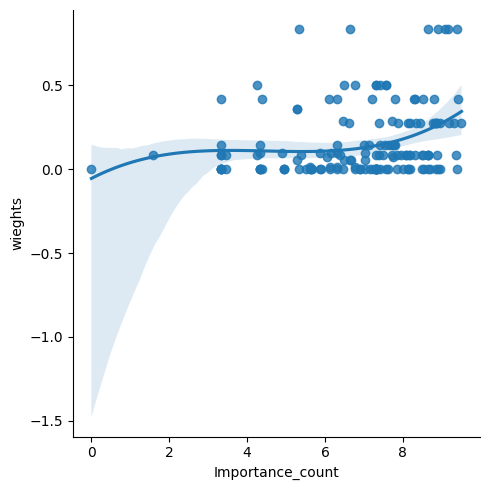


     Importance_count   wieghts              level play-style
SDP          5.882643  0.094286  holmgard_1_switch     switch
SDT          7.787903  0.142857  holmgard_1_switch     switch
DM                NaN       NaN                NaN        NaN
DP                NaN       NaN                NaN        NaN
DT                NaN       NaN                NaN        NaN
..                ...       ...                ...        ...
DT                NaN       NaN                NaN        NaN
DP                NaN       NaN                NaN        NaN
SDT               NaN       NaN                NaN        NaN
SDE               NaN       NaN                NaN        NaN
DE                NaN       NaN                NaN        NaN

[155 rows x 4 columns]
     Importance_count   wieghts            level play-style
SDP               NaN       NaN              NaN        NaN
SDT               NaN       NaN              NaN        NaN
DM           6.321928  0.142857  holmgard_1_hard   

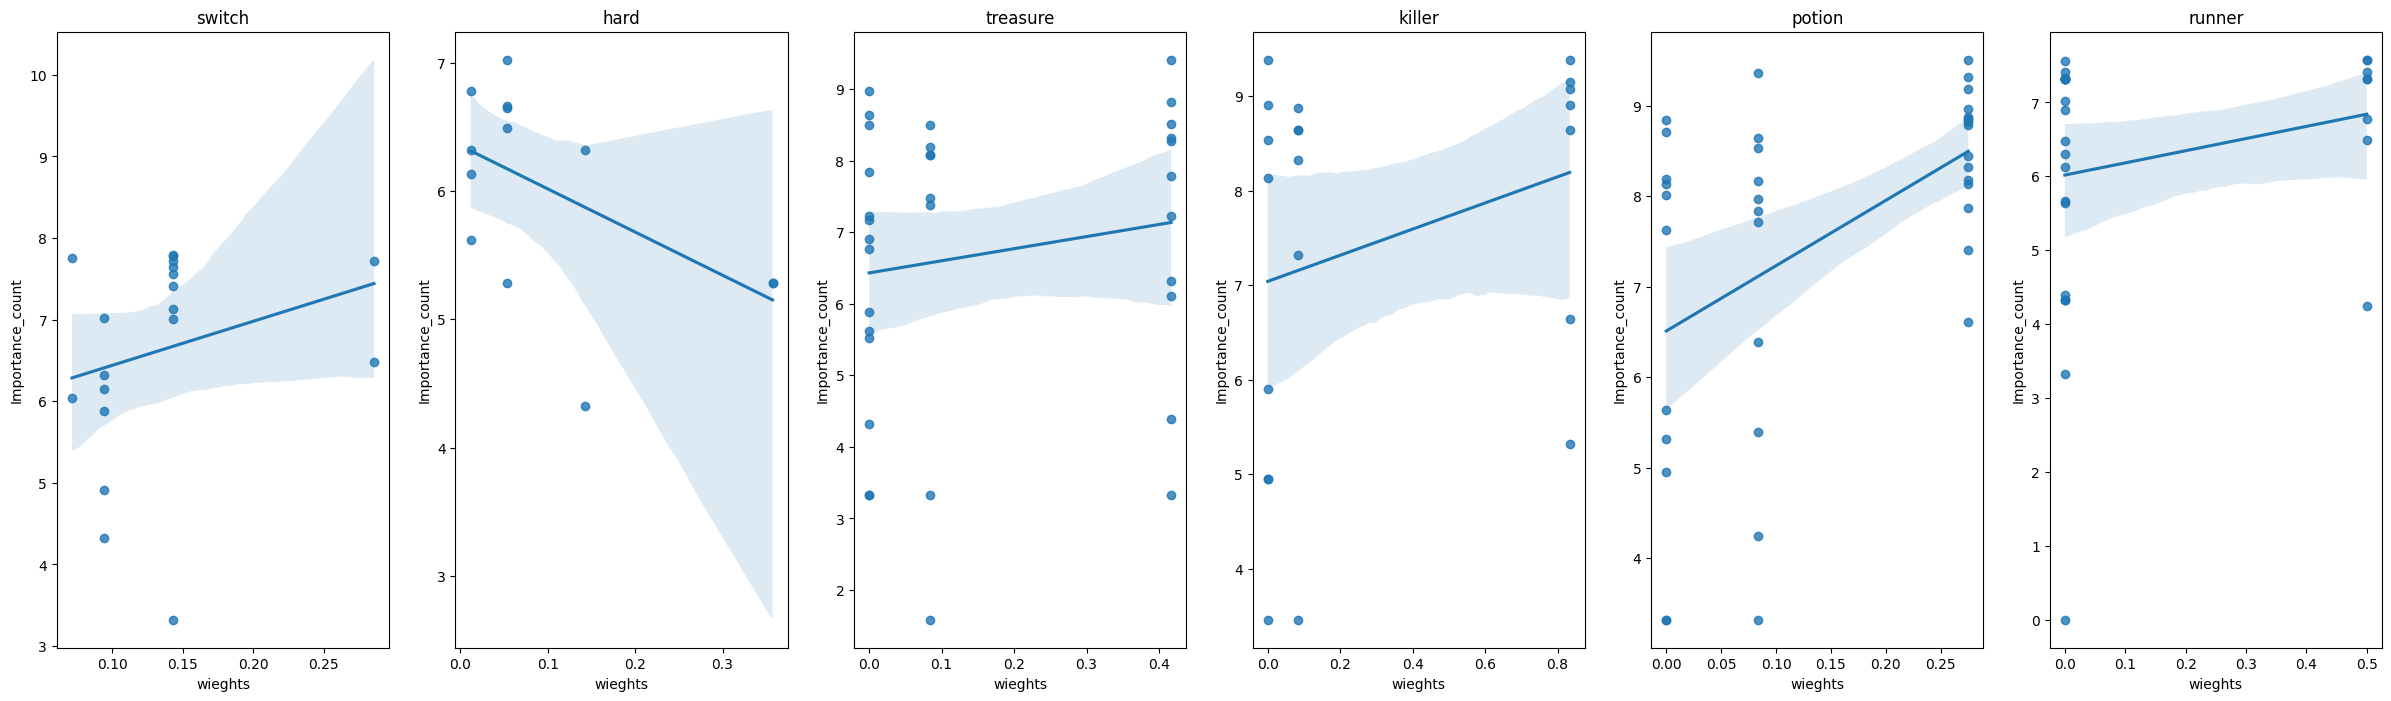

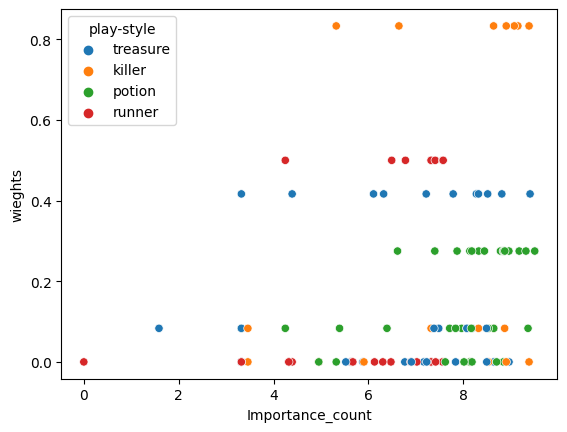

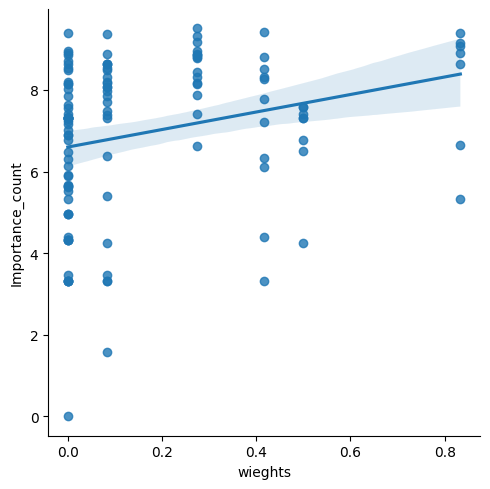

In [ ]:

from sklearn.preprocessing import RobustScaler, quantile_transform
from sklearn import linear_model


transformer = RobustScaler()
# merged_df = pd.concat(df_list,keys=['switch','hard','treasure','killer','potion','runner'])
# print(df_list)
# df_list['play_style'] = df_list['level'].str.split("_")
# print(df_list['level'])
# df_list['play_style'] = [x.split('_') for x in df_list['level']]

merged_df = pd.concat(df_list)
# merged_df['wieghts'] = np.log(merged_df['wieghts'])
# merged_df['Importance_count'] = np.log(merged_df['Importance_count'])

# normalizer = preprocessing.StandardScaler()
print(merged_df[["Importance_count","wieghts"]])
# merged_df["wieghts"] = merged_df['wieghts'].replace(0.0 , 0.001)
# normalizer = preprocessing.MinMaxScaler()



merged_df["play-style"] = merged_df['level'].str.split('_').str[-1]
print(merged_df.describe())
print(merged_df[merged_df['Importance_count']==0])

ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',hue="play-style")
plt.show()
sns.regplot(x = "Importance_count", y = 'wieghts', data= merged_df,robust=True,fit_reg=True)
plt.show()
merged_df = merged_df[merged_df.groupby(['play-style'])['Importance_count'].transform(stats.zscore).abs() < 2.5]
# merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='Importance_count')
non_complex_df = merged_df[(merged_df['play-style']!= 'switch') & (merged_df['play-style']!= 'hard')]


# ax =sns.scatterplot(data=non_complex_df, x = 'Importance_count', y= 'wieghts',hue="play-style")
# plt.show()
# sns.regplot(y = "Importance_count", x = 'wieghts', data= non_complex_df)
# plt.show()
# sns.regplot(x = "Importance_count", y = 'wieghts', data= non_complex_df)
# plt.show()

# standardise data based of every level
# merged_df = groupwise_normalize(df=merged_df, group_column='level', numeric_column='wieghts')
# merged_df = groupwise_normalize(df=merged_df, group_column='play-style', numeric_column='Importance_count')

from sklearn.preprocessing import PowerTransformer,QuantileTransformer
power = PowerTransformer(standardize=True)
quantile_transformer = QuantileTransformer(n_quantiles=50,random_state=0,ignore_implicit_zeros=True)
# scaled = normalizer.fit_transform(merged_df[["Importance_count","wieghts"]].values)
# merged_df["Importance_count"] = scaled[:,0]
# merged_df["wieghts"] = scaled[:,1]
# merged_df['wieghts'] = np.log2(merged_df['wieghts'])
merged_df['Importance_count'] = np.log2(merged_df['Importance_count'])
#power transformer
# merged_df['wieghts'] = power.fit_transform(merged_df['wieghts'].to_numpy().reshape(-1,1))
# merged_df['Importance_count'] = power.fit_transform(merged_df['Importance_count'].to_numpy().reshape(-1,1))

#quantile_transformer
# merged_df['wieghts'] = quantile_transformer.fit_transform(merged_df['wieghts'].to_numpy().reshape(-1,1))
# merged_df['Importance_count'] = quantile_transformer.fit_transform(merged_df['Importance_count'].to_numpy().reshape(-1,1))

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=["Importance_count", "wieghts"], how="all", inplace=True)

ax =sns.scatterplot(data=non_complex_df, x = 'Importance_count', y= 'wieghts',hue="play-style")
plt.show()
sns.regplot(y = "Importance_count", x = 'wieghts', data= non_complex_df)
plt.show()
sns.regplot(x = "Importance_count", y = 'wieghts', data= non_complex_df)
plt.show()
# reg = linear_model.LinearRegression().fit(merged_df['Importance_count'].values,merged_df['wieghts'].values)
# sns.scatterplot(data=merged_df, x = np.log(merged_df['Importance_count']), y= np.log(merged_df['wieghts']))
# sns.scatterplot(data=merged_df, x = np.exp(merged_df['Importance_count']), y= np.exp(merged_df['wieghts']))
# sns.scatterplot(data=merged_df, x = np.exp(merged_df['Importance_count']), y= np.exp(merged_df['wieghts']))
ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts', hue = "play-style")
plt.show()
# plt.plot(merged_df['Importance_count'].values.T,reg.predict(merged_df['Importance_count'].values.T),ax=ax)
sns.lmplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts',order=3)
# sns.jointplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts',kind = "reg")
plt.show()
merged_df
print()

fig, ax = plt.subplots(1,len(merged_df['play-style'].unique()),figsize=(30,8))
for i , play_style in enumerate(merged_df['play-style'].unique()):
        # play_style_df = merged_df.where(merged_df['play-style']==play_style)
        # play_style_df = outlier_removal(play_style_df["Importance_count"])
        print(merged_df.where(merged_df['play-style']==play_style))
        sns.regplot(y = "Importance_count", x = 'wieghts', data= merged_df.where(merged_df['play-style']==play_style), ax = ax[i]).set(title =play_style)

plt.show()
df_shap
#TODO look intoswapping axis 
#TODO look into plotting ploting and looking at complet and non complex play-styles

# complex vs non complex play-styles
# non_complex_df = merged_df.where(merged_df['play-style'] != "switch" | merged_df['play-style'] != "hard"])
non_complex_df = merged_df[(merged_df['play-style']!= 'switch') & (merged_df['play-style']!= 'hard')]
non_complex_df

# fig, ax = plt.subplots(1,len(non_complex_df['play-style'].unique()),figsize=(30,8))
# for i , play_style in enumerate(non_complex_df['play-style'].unique()):
#         # play_style_df = merged_df.where(merged_df['play-style']==play_style)
#         # play_style_df = outlier_removal(play_style_df["Importance_count"])
#         print(merged_df.where(merged_df['play-style']==play_style))
#         sns.regplot(y = "Importance_count", x = 'wieghts', data= merged_df.where(merged_df['play-style']==play_style), ax = ax[i]).set(title =play_style)

ax =sns.scatterplot(data=non_complex_df, x = 'Importance_count', y= 'wieghts', hue = "play-style")
plt.show()
# plt.plot(merged_df['Importance_count'].values.T,reg.predict(merged_df['Importance_count'].values.T),ax=ax)
sns.lmplot(data=non_complex_df[['Importance_count','wieghts']], y = 'Importance_count', x= 'wieghts')
# sns.jointplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts',kind = "reg")
plt.show()
#TODO look into using the transmormers on a play-style level
#TODO get corrolations
#TODO use argtsort for nucleus sampling

      Importance_count   wieghts              level
0                 59.0  0.094286  holmgard_1_switch
1                221.0  0.142857  holmgard_1_switch
2                 80.0  0.142857    holmgard_1_hard
3                 80.0  0.011786    holmgard_1_hard
4                101.0  0.053571    holmgard_1_hard
...                ...       ...                ...
1038              70.0  0.000000  holmgard_9_runner
1039             171.0  0.000000  holmgard_9_runner
1040             190.0  0.500000  holmgard_9_runner
1041             191.0  0.500000  holmgard_9_runner
1042             210.0  0.000000  holmgard_9_runner

[1043 rows x 3 columns]
      Importance_count   wieghts              level
0                 59.0  0.094286  holmgard_1_switch
1                221.0  0.142857  holmgard_1_switch
2                 80.0  0.142857    holmgard_1_hard
3                 80.0  0.011786    holmgard_1_hard
4                101.0  0.053571    holmgard_1_hard
...                ...       ...       

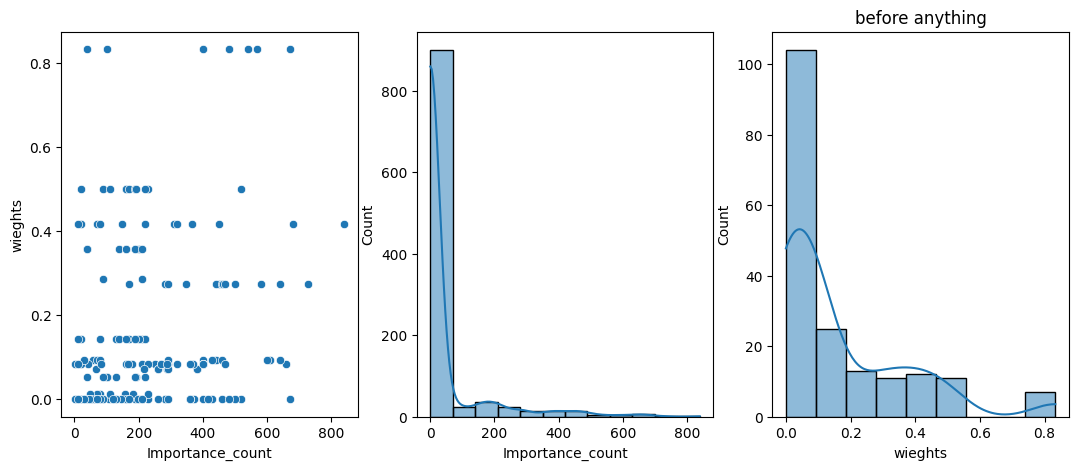

dsufuisgufis
       Importance_count   wieghts              level
0             0.000000  0.094286  holmgard_1_switch
1             1.000000  0.142857  holmgard_1_switch
2             0.000000  0.142857    holmgard_1_hard
3             0.000000  0.011786    holmgard_1_hard
4             0.262500  0.053571    holmgard_1_hard
...                ...       ...                ...
1038          0.330144  0.000000  holmgard_9_runner
1039          0.813397  0.000000  holmgard_9_runner
1040          0.904306  0.500000  holmgard_9_runner
1041          0.909091  0.500000  holmgard_9_runner
1042          1.000000  0.000000  holmgard_9_runner

[1043 rows x 3 columns]


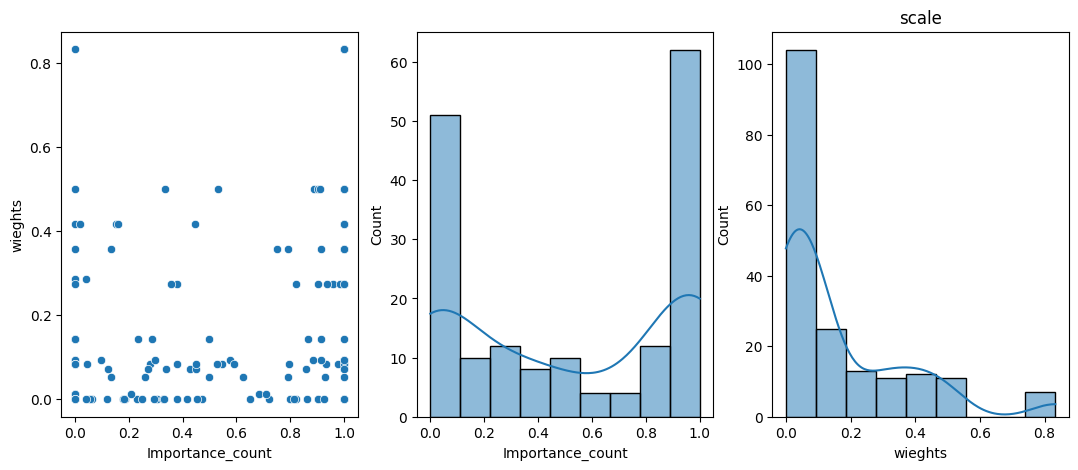

      Importance_count   wieghts              level
0             0.000000  0.094286  holmgard_1_switch
1             1.000000  0.142857  holmgard_1_switch
2             0.000000  0.142857    holmgard_1_hard
3             0.000000  0.011786    holmgard_1_hard
4             0.262500  0.053571    holmgard_1_hard
...                ...       ...                ...
1038          0.330144  0.000000  holmgard_9_runner
1039          0.813397  0.000000  holmgard_9_runner
1040          0.904306  0.500000  holmgard_9_runner
1041          0.909091  0.500000  holmgard_9_runner
1042          1.000000  0.000000  holmgard_9_runner

[1043 rows x 3 columns]


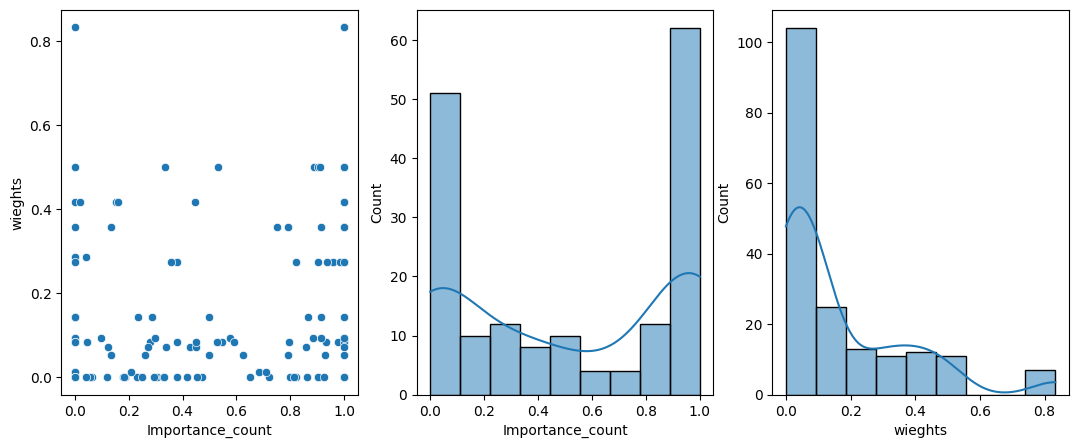

None


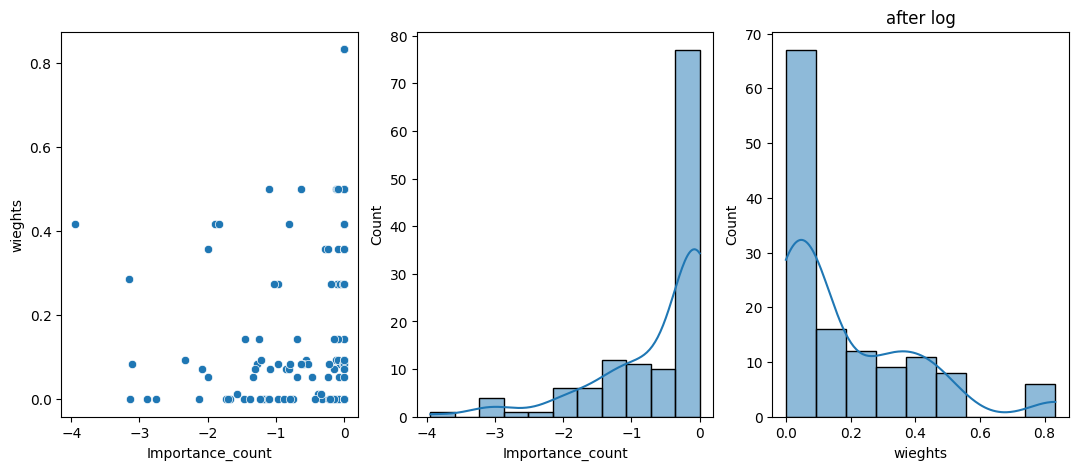

129


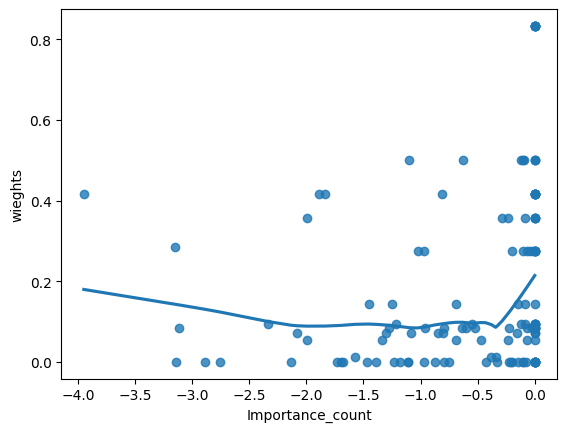

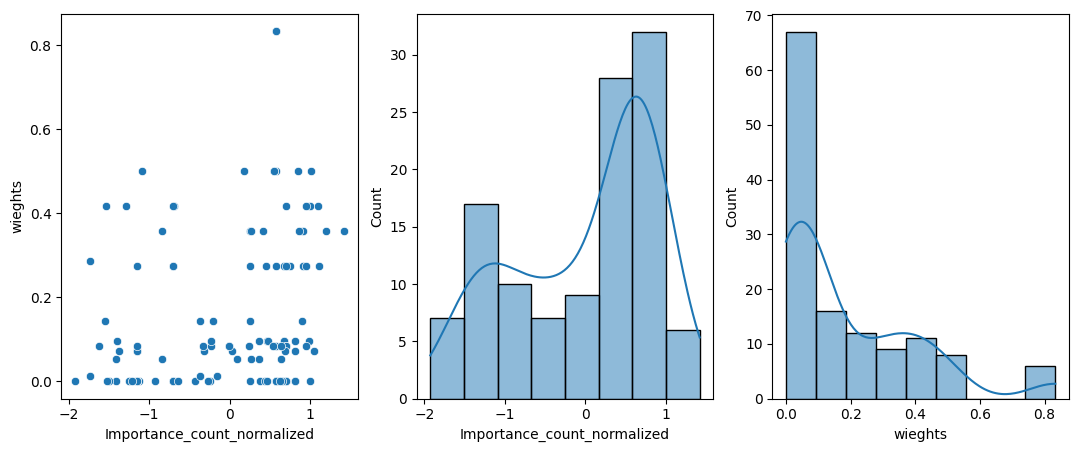

      Importance_count   wieghts              level  \
1             0.000000  0.142857  holmgard_1_switch   
4            -1.337504  0.053571    holmgard_1_hard   
5            -0.470004  0.053571    holmgard_1_hard   
6            -0.287682  0.357143    holmgard_1_hard   
7             0.000000  0.357143    holmgard_1_hard   
...                ...       ...                ...   
1038         -1.108228  0.000000  holmgard_9_runner   
1039         -0.206536  0.000000  holmgard_9_runner   
1040         -0.100587  0.500000  holmgard_9_runner   
1041         -0.095310  0.500000  holmgard_9_runner   
1042          0.000000  0.000000  holmgard_9_runner   

      Importance_count_normalized  wieghts_normalized  
1                             NaN                 NaN  
4                       -1.412828           -0.866025  
5                        0.093402           -0.866025  
6                        0.409964            0.866025  
7                        0.909463            0.866025  
...

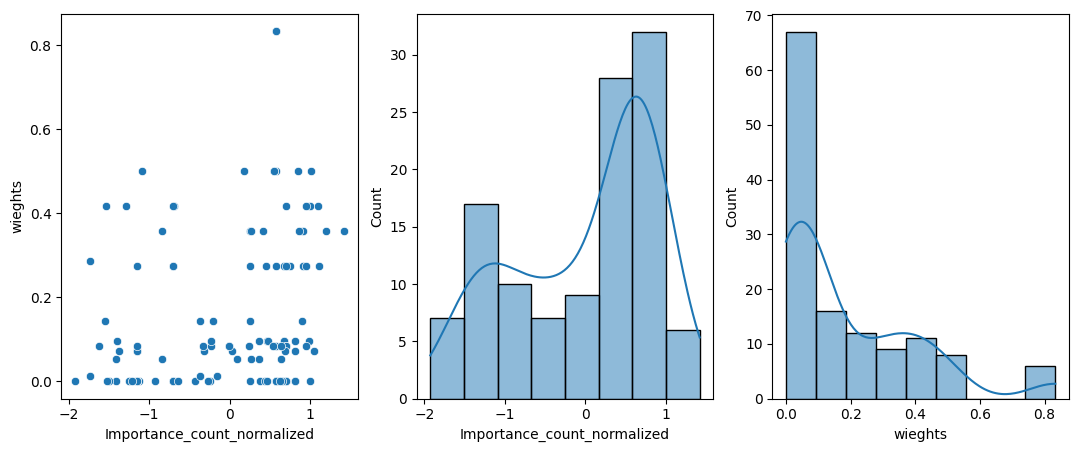

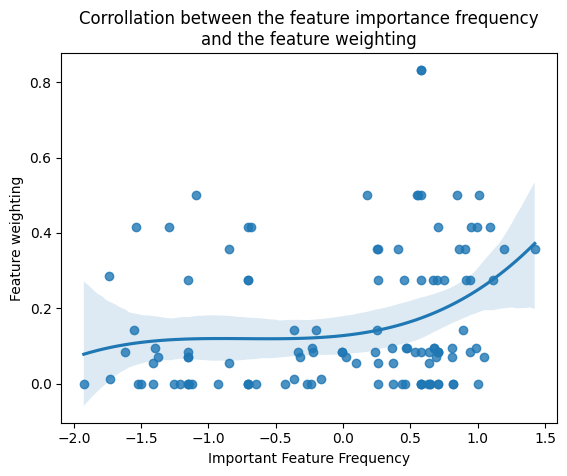

In [20]:



from pandas import DataFrame
from scipy import stats

groups_by_reward={
    "Exit": ["DE","SDE"],
    "Treasure": ["DT","SDT"],
    "Kill":["DM"],
    "Potion":["SDP","DP"],
    "HP": ["HP"]
}


def outlier_removal(df:DataFrame):
    return df[(np.abs(stats.zscore(df)) < 2.75).all(axis=1)]


def groupwise_scale(df:DataFrame, group_column, numeric_column)->DataFrame:
    # Initialize StandardScaler
    # Group by the categorical column
    grouped = df.groupby(group_column)
    #remove otliers before scalling
    # Normalize the numeric column within each group
    df[numeric_column] = grouped[numeric_column].transform(lambda x: (x - x.min())/ (x.max() - x.min()))

    return df

def groupwise_normalize(df:DataFrame, group_column, numeric_column)->DataFrame:
    # Initialize StandardScaler
    # Group by the categorical column
    grouped = df.groupby(group_column)
    # Normalize the numeric column within each group
    df[numeric_column + '_normalized'] = grouped[numeric_column].transform(lambda x: (x - x.mean()) / x.std())
    return df


fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
for df in df_list:
    try:
        df.drop("HP",inplace=True)
    except:
        pass
# df_list["play-style"] = df_list['level'].str.split("_").str[-1]
merged_df = pd.concat(df_list,ignore_index=True)
print(merged_df)
# merged_df.drop("HP",inplace=True)
merged_df.reset_index(drop=True)
print(merged_df)

# plot before any preprocessing
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.title("before anything")
plt.show()

merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='Importance_count')
# merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='wieghts')
# merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='wieghts')
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
print("dsufuisgufis\n",merged_df)
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.title("scale")
plt.show()

# cleaned_df = outlier_removal(merged_df[["Importance_count"]])
# print(cleaned_df)
# merged_df = merged_df.loc[set(merged_df.index) - set(list(cleaned_df.index))]
# merged_df =merged_df[merged_df.index.isin(cleaned_df.index)]
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
print(merged_df)
plt.show()


# log data
# merged_df['wieghts'] = np.log(merged_df['wieghts'])
merged_df['Importance_count'] = np.log(merged_df['Importance_count'])
# from sklearn.preprocessing import PowerTransformer
# power = PowerTransformer(method='box-cox', standardize=True)
# merged_df['Importance_count'] = 
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(merged_df.dropna(subset=["Importance_count", "wieghts"], how="any", inplace=True))

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.title("after log")
plt.show()
print(len(merged_df))
sns.regplot(data=merged_df, x = 'Importance_count', y= 'wieghts', lowess=True)
plt.show()
# remove outliers
# cleaned_df = outlier_removal(merged_df[["Importance_count"]])
# print(cleaned_df)
# # merged_df = merged_df.loc[set(merged_df.index) - set(list(cleaned_df.index))]
# merged_df =merged_df[merged_df.index.isin(cleaned_df.index)]
# fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
# sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
# sns.kdeplot(data=merged_df, x = 'Importance_count',ax=ax[1])
# sns.kdeplot(data=merged_df, x = 'wieghts',ax=ax[2])
# print(merged_df)
# plt.show()

# normalize_data
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
merged_df = groupwise_normalize(df=merged_df, group_column='level', numeric_column='Importance_count')
merged_df = groupwise_normalize(df=merged_df, group_column='level', numeric_column='wieghts')

sns.scatterplot(data=merged_df, x = 'Importance_count_normalized', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count_normalized',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.show()

# remove outliers
# cleaned_df = outlier_removal(merged_df[["Importance_count_normalized"]])
# print(cleaned_df)
# # merged_df = merged_df.loc[set(merged_df.index) - set(list(cleaned_df.index))]
# merged_df =merged_df[merged_df.index.isin(cleaned_df.index)]
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
sns.scatterplot(data=merged_df, x = 'Importance_count_normalized', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count_normalized',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
print(merged_df)
plt.show()

ax = plt.axes()
sns.regplot(data=merged_df[['Importance_count_normalized','wieghts']], x = 'Importance_count_normalized', y= 'wieghts',order=3,ax =ax)
ax.set_title("Corrollation between the feature importance frequency\nand the feature weighting")
ax.set_ylabel("Feature weighting")
ax.set_xlabel("Important Feature Frequency")
plt.show()


In [ ]:
#gen analysis for all the levels
# from IPython.display import clear_output
# EXPLAINER_TYPE = 'deep'
# CLASS_NAMES =['Killer','Treasure','Runner','Potion']
# for lvl in lvl_list:
#     # gen_analysis(analysis_loc='./test_analysis/Holmgard_2_Analysis/', lvl='holmgard_2', obs_type = 'distance', explainer_type =EXPLAINER_TYPE)
#     gen_analysis(analysis_loc=f'./test_analysis/{lvl.capitalize()}_Analysis/',lvl=lvl, obs_type='distance', explainer_type='deep',exp_type='switch_analysis',exp_path = 'switching_analysis', base_path='play_style_models/base/')
#     plt.close()
#     clear_output()

     Importance_count   wieghts
DE              129.0  0.071429
DT              140.0  0.142857
SDT             250.0  0.142857
DM              810.0  0.285714
DP              820.0  0.094286
..                ...       ...
DP              149.0  0.000000
SDT             200.0  0.000000
DE              210.0  0.500000
SDE             210.0  0.500000
SDP             210.0  0.000000

[423 rows x 2 columns]
       Importance_count     wieghts
count        423.000000  423.000000
mean         307.484634    0.138054
std          227.627167    0.187451
min           10.000000    0.000000
25%          130.500000    0.000000
50%          260.000000    0.083333
75%          450.500000    0.142857
max         1230.000000    0.833333
Empty DataFrame
Columns: [Importance_count, wieghts, level, play-style]
Index: []


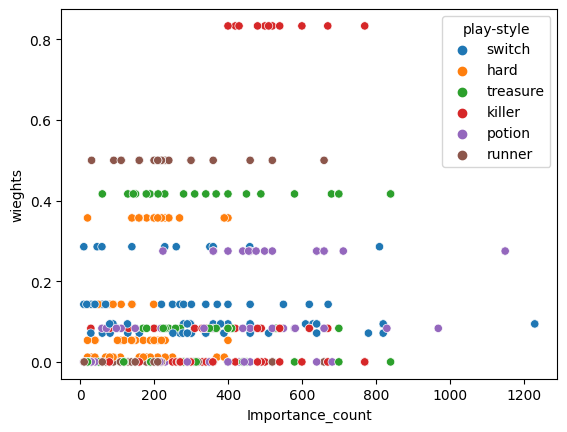

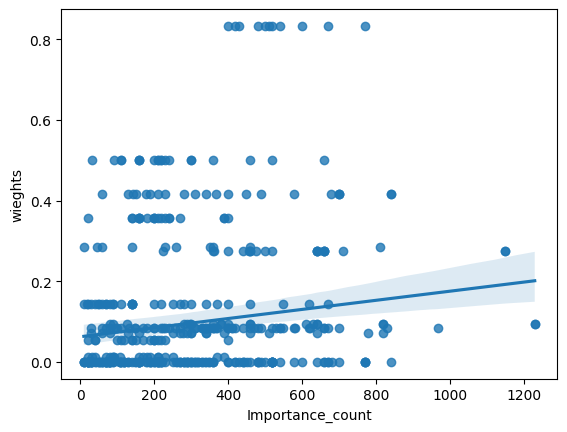

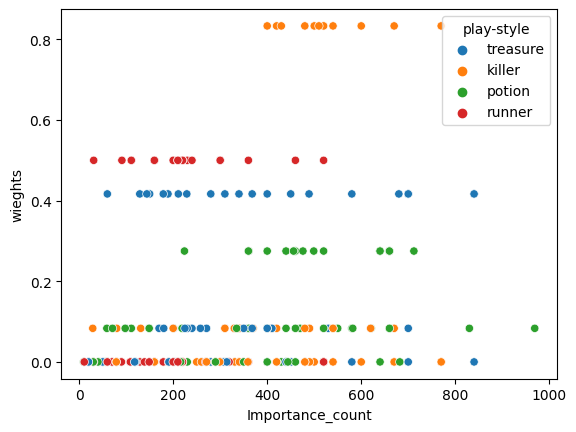

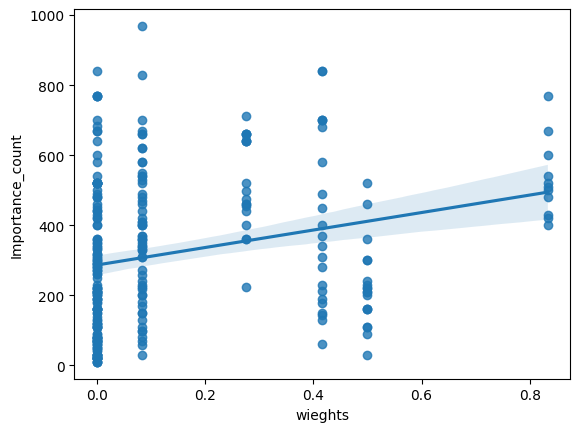

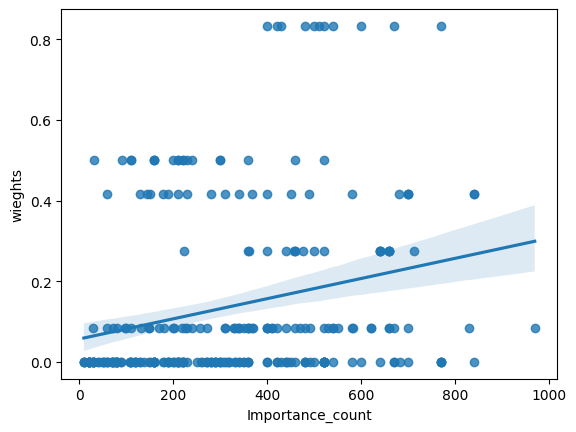

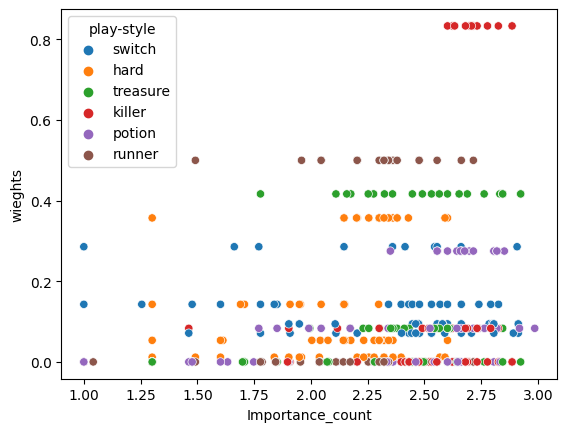

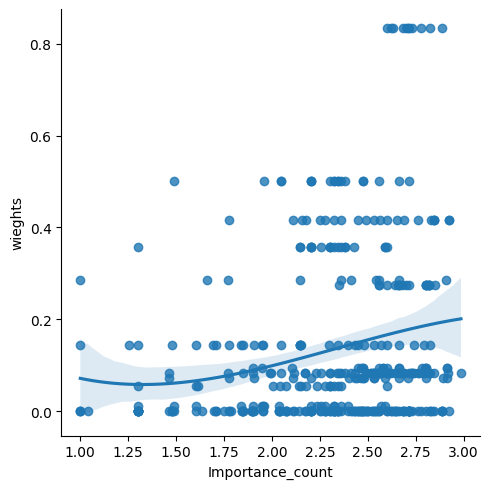


     Importance_count   wieghts        level play-style  wieghts_normalized  \
DE           2.110590  0.071429  hard_switch     switch           -0.764717   
DT           2.146128  0.142857  hard_switch     switch            0.184400   
SDT          2.397940  0.142857  hard_switch     switch            0.184400   
DM           2.908485  0.285714  hard_switch     switch            2.082634   
DP           2.913814  0.094286  hard_switch     switch           -0.461000   
..                ...       ...          ...        ...                 ...   
DP                NaN       NaN          NaN        NaN                 NaN   
SDT               NaN       NaN          NaN        NaN                 NaN   
DE                NaN       NaN          NaN        NaN                 NaN   
SDE               NaN       NaN          NaN        NaN                 NaN   
SDP               NaN       NaN          NaN        NaN                 NaN   

     Importance_count_normalized  
DE             

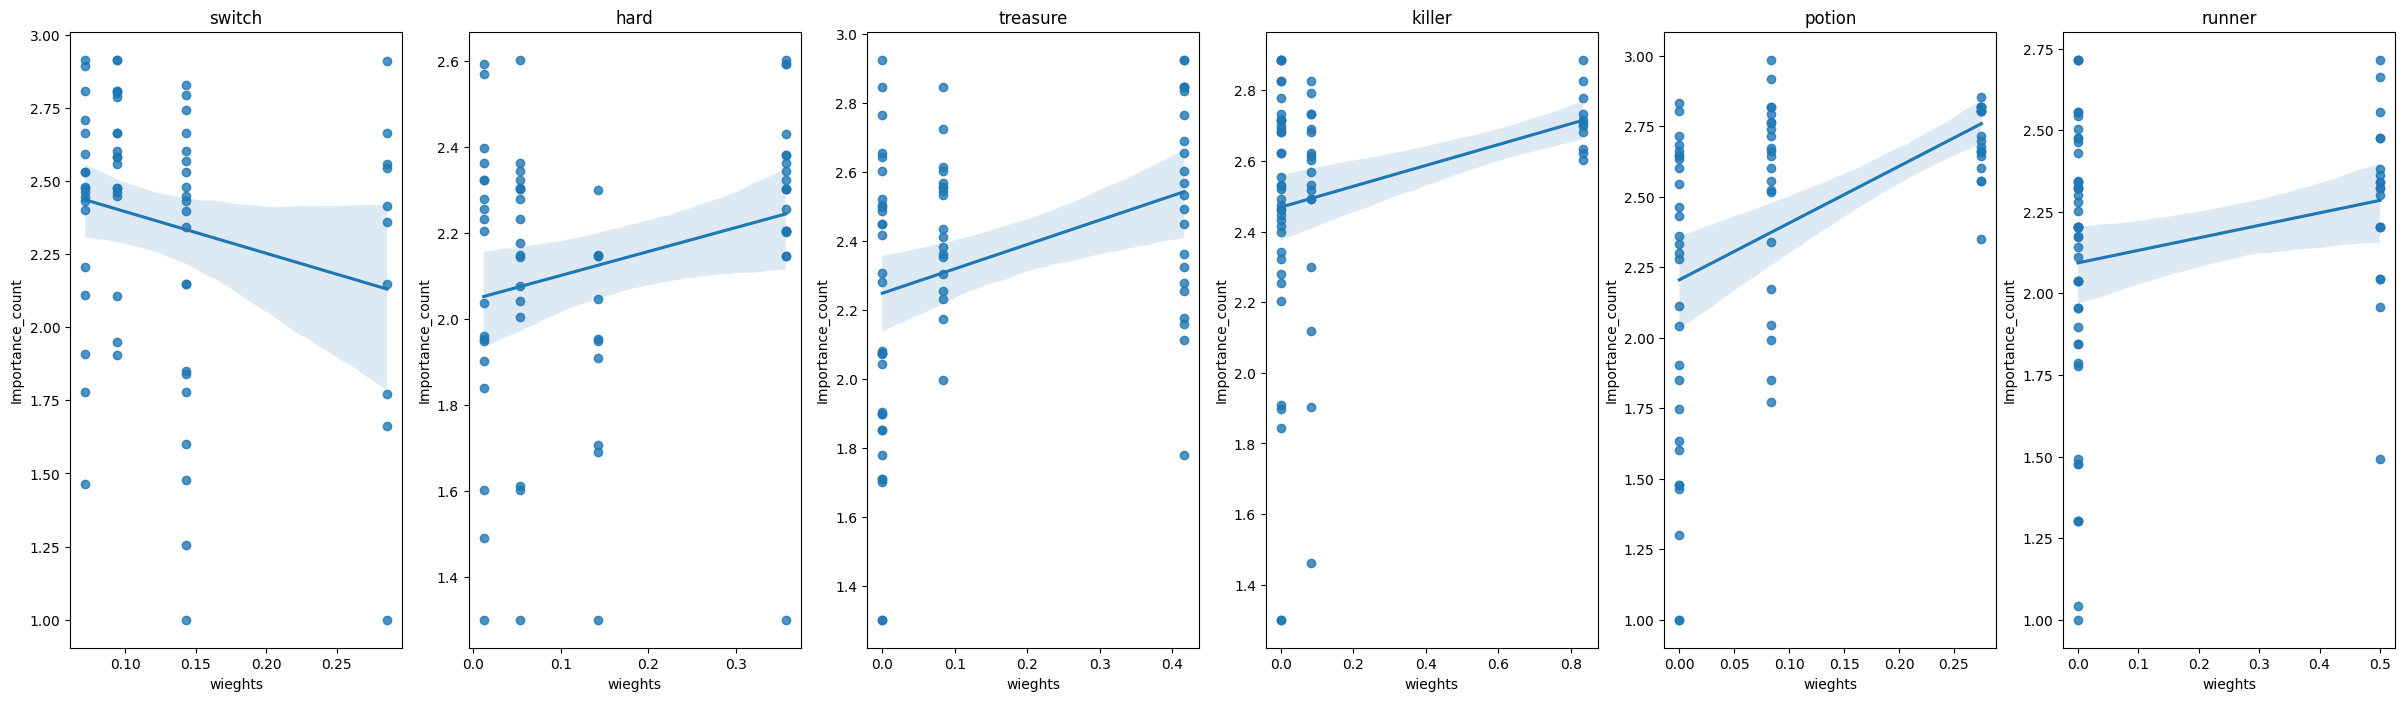

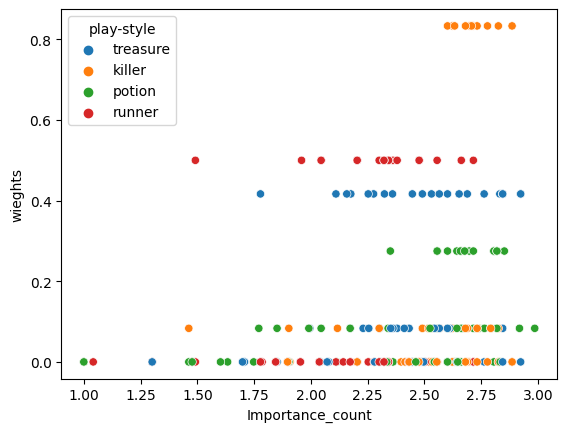

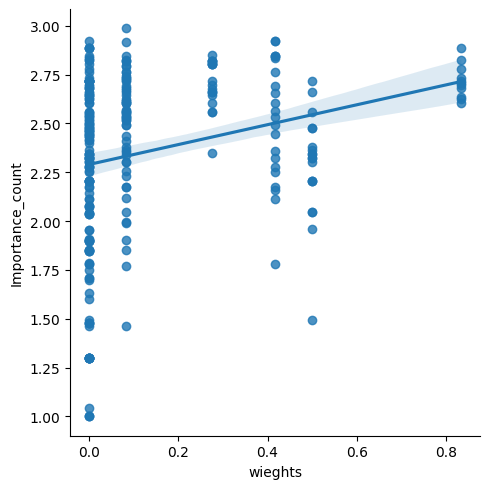

In [86]:
from sklearn.preprocessing import RobustScaler, quantile_transform
from sklearn import linear_model


transformer = RobustScaler()
# merged_df = pd.concat(df_list,keys=['switch','hard','treasure','killer','potion','runner'])
# print(df_list)
# df_list['play_style'] = df_list['level'].str.split("_")
# print(df_list['level'])
# df_list['play_style'] = [x.split('_') for x in df_list['level']]

merged_df = pd.concat(df_list)
# merged_df['wieghts'] = np.log(merged_df['wieghts'])
# merged_df['Importance_count'] = np.log(merged_df['Importance_count'])

# normalizer = preprocessing.StandardScaler()
print(merged_df[["Importance_count","wieghts"]])
# merged_df["wieghts"] = merged_df['wieghts'].replace(0.0 , 0.001)
# normalizer = preprocessing.MinMaxScaler()



merged_df["play-style"] = merged_df['level'].str.split('_').str[-1]
print(merged_df.describe())
print(merged_df[merged_df['Importance_count']==0])

ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',hue="play-style")
plt.show()
sns.regplot(x = "Importance_count", y = 'wieghts', data= merged_df,robust=True,fit_reg=True)
plt.show()
merged_df = merged_df[merged_df.groupby(['play-style'])['Importance_count'].transform(stats.zscore).abs() < 2.5]
# merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='Importance_count')
non_complex_df = merged_df[(merged_df['play-style']!= 'switch') & (merged_df['play-style']!= 'hard')]


# ax =sns.scatterplot(data=non_complex_df, x = 'Importance_count', y= 'wieghts',hue="play-style")
# plt.show()
# sns.regplot(y = "Importance_count", x = 'wieghts', data= non_complex_df)
# plt.show()
# sns.regplot(x = "Importance_count", y = 'wieghts', data= non_complex_df)
# plt.show()

# standardise data based of every level
merged_df = groupwise_normalize(df=merged_df, group_column='level', numeric_column='wieghts')
merged_df = groupwise_normalize(df=merged_df, group_column='play-style', numeric_column='Importance_count')

from sklearn.preprocessing import PowerTransformer,QuantileTransformer
power = PowerTransformer(standardize=True)
quantile_transformer = QuantileTransformer(n_quantiles=50,random_state=0,ignore_implicit_zeros=True)
# scaled = normalizer.fit_transform(merged_df[["Importance_count","wieghts"]].values)
# merged_df["Importance_count"] = scaled[:,0]
# merged_df["wieghts"] = scaled[:,1]
# merged_df['wieghts'] = np.log2(merged_df['wieghts'])
merged_df['Importance_count'] = np.log10(merged_df['Importance_count'])
#power transformer
# merged_df['wieghts'] = power.fit_transform(merged_df['wieghts'].to_numpy().reshape(-1,1))
# merged_df['Importance_count'] = power.fit_transform(merged_df['Importance_count'].to_numpy().reshape(-1,1))

#quantile_transformer
# merged_df['wieghts'] = quantile_transformer.fit_transform(merged_df['wieghts'].to_numpy().reshape(-1,1))
# merged_df['Importance_count'] = quantile_transformer.fit_transform(merged_df['Importance_count'].to_numpy().reshape(-1,1))

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=["Importance_count", "wieghts"], how="all", inplace=True)

ax =sns.scatterplot(data=non_complex_df, x = 'Importance_count', y= 'wieghts',hue="play-style")
plt.show()
sns.regplot(y = "Importance_count", x = 'wieghts', data= non_complex_df)
plt.show()
sns.regplot(x = "Importance_count", y = 'wieghts', data= non_complex_df)
plt.show()
# reg = linear_model.LinearRegression().fit(merged_df['Importance_count'].values,merged_df['wieghts'].values)
# sns.scatterplot(data=merged_df, x = np.log(merged_df['Importance_count']), y= np.log(merged_df['wieghts']))
# sns.scatterplot(data=merged_df, x = np.exp(merged_df['Importance_count']), y= np.exp(merged_df['wieghts']))
# sns.scatterplot(data=merged_df, x = np.exp(merged_df['Importance_count']), y= np.exp(merged_df['wieghts']))
ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts', hue = "play-style")
plt.show()
# plt.plot(merged_df['Importance_count'].values.T,reg.predict(merged_df['Importance_count'].values.T),ax=ax)
sns.lmplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts',order=3)
# sns.jointplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts',kind = "reg")
plt.show()
merged_df
print()

fig, ax = plt.subplots(1,len(merged_df['play-style'].unique()),figsize=(30,8))
for i , play_style in enumerate(merged_df['play-style'].unique()):
        # play_style_df = merged_df.where(merged_df['play-style']==play_style)
        # play_style_df = outlier_removal(play_style_df["Importance_count"])
        print(merged_df.where(merged_df['play-style']==play_style))
        sns.regplot(y = "Importance_count", x = 'wieghts', data= merged_df.where(merged_df['play-style']==play_style), ax = ax[i]).set(title =play_style)

plt.show()
df_shap
#TODO look intoswapping axis 
#TODO look into plotting ploting and looking at complet and non complex play-styles

# complex vs non complex play-styles
# non_complex_df = merged_df.where(merged_df['play-style'] != "switch" | merged_df['play-style'] != "hard"])
non_complex_df = merged_df[(merged_df['play-style']!= 'switch') & (merged_df['play-style']!= 'hard')]
non_complex_df

# fig, ax = plt.subplots(1,len(non_complex_df['play-style'].unique()),figsize=(30,8))
# for i , play_style in enumerate(non_complex_df['play-style'].unique()):
#         # play_style_df = merged_df.where(merged_df['play-style']==play_style)
#         # play_style_df = outlier_removal(play_style_df["Importance_count"])
#         print(merged_df.where(merged_df['play-style']==play_style))
#         sns.regplot(y = "Importance_count", x = 'wieghts', data= merged_df.where(merged_df['play-style']==play_style), ax = ax[i]).set(title =play_style)

ax =sns.scatterplot(data=non_complex_df, x = 'Importance_count', y= 'wieghts', hue = "play-style")
plt.show()
# plt.plot(merged_df['Importance_count'].values.T,reg.predict(merged_df['Importance_count'].values.T),ax=ax)
sns.lmplot(data=non_complex_df[['Importance_count','wieghts']], y = 'Importance_count', x= 'wieghts')
# sns.jointplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts',kind = "reg")
plt.show()
#TODO look into using the transmormers on a play-style level
#TODO get corrolations
#TODO use argtsort for nucleus sampling

{'DE': 0.08333333333333333, 'SDE': 0.08333333333333333, 'DT': 0.4166666666666667, 'SDT': 0.4166666666666667, 'DM': 0.0, 'DP': 0.0, 'SDP': 0.0, 'HP': 0.0}


<Axes: xlabel='wieghts', ylabel='Importance_count'>

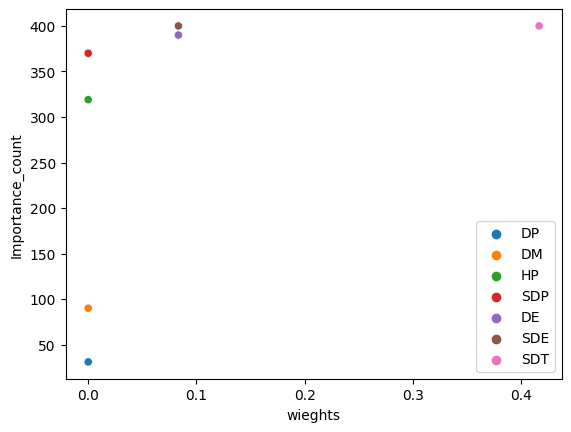

In [63]:

df_shap = df[['level','curr_obs', 'action']]
shap_valss = []
policy_classes = ['killer','treasure','runner','potion']

reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
action_shap_vals=[]
for i, row in df.iterrows():
    action = row['action']
    # get action taken index
    action_idx = policy_classes.index(action.lower())
    action_shap_vals.append(reshaped_shap_vals[i][action_idx])

# Add shap_vals to the dataframe
df_shap["shap_vals"] = pd.Series(action_shap_vals)
df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

# get the top five features for each state
df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))

# create rankings dataframe for the whole level by adding up the value counts
df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')
imp_w = get_imporance_weights("treasure")
df_rankings['wieghts'] = df_rankings.index.map(imp_w)
# df_rankings =df_rankings.T
df_rankings['level'] = df_shap['level'].unique()[0]
# df_rankings

print(imp_w)
df_rankings
sns.scatterplot(data =df_rankings, x = 'wieghts',y ="Importance_count",hue=df_rankings.index)

# df_shap

## gen Data

10
----------Generating Action Data----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_switch_switch_grid_12x12_switch_analysis_PPO


[ WARN:0@6.010] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_hard_hard_grid_12x12_switch_analysis_PPO


[ WARN:0@8.222] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_treasure_treasure_grid_12x12_switch_analysis_PPO


[ WARN:0@10.179] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'killer', 'reward_scheme': 'killer', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_killer_killer_grid_12x12_switch_analysis_PPO


[ WARN:0@11.726] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'potion', 'reward_scheme': 'potion', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_potion_potion_grid_12x12_switch_analysis_PPO


[ WARN:0@13.803] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'runner', 'reward_scheme': 'runner', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_runner_runner_grid_12x12_switch_analysis_PPO


[ WARN:0@14.705] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'treasure', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_treasure_fiftytwoFifty_treasure_PPO


[ WARN:0@15.756] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'killer', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'killer', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_killer_fiftytwoFifty_killer_PPO


[ WARN:0@16.999] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'potion', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'potion', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_potion_fiftytwoFifty_potion_PPO


[ WARN:0@37.575] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'runner', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'runner', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_runner_fiftytwoFifty_runner_PPO


[ WARN:0@38.002] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


<Figure size 640x480 with 0 Axes>

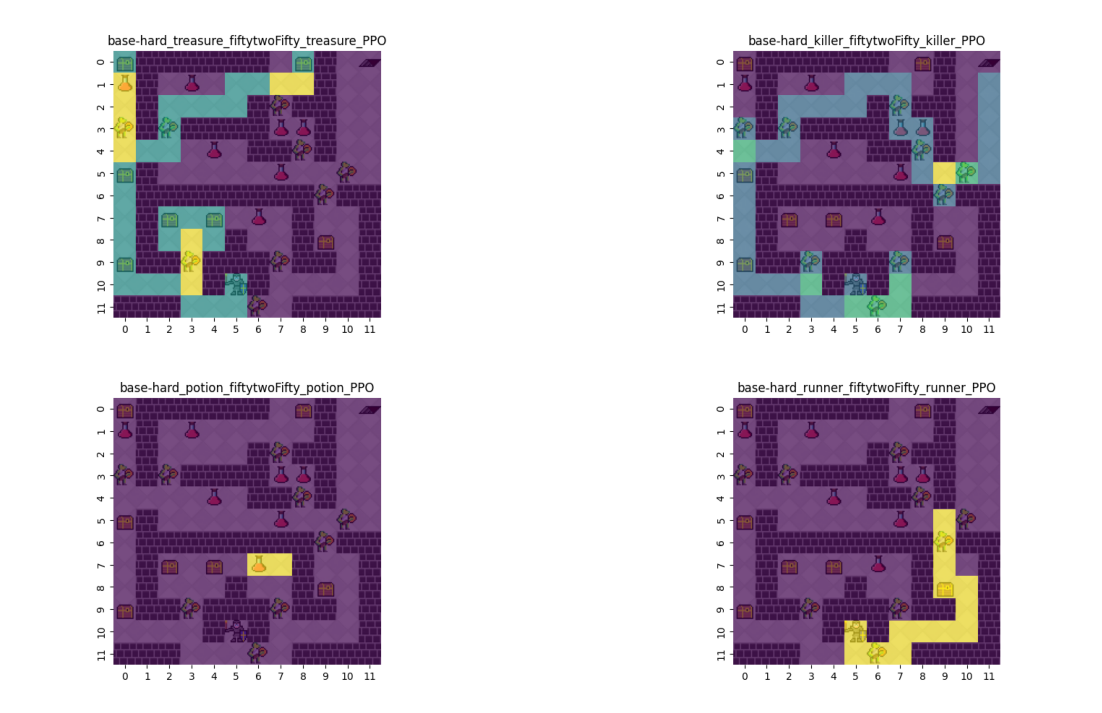

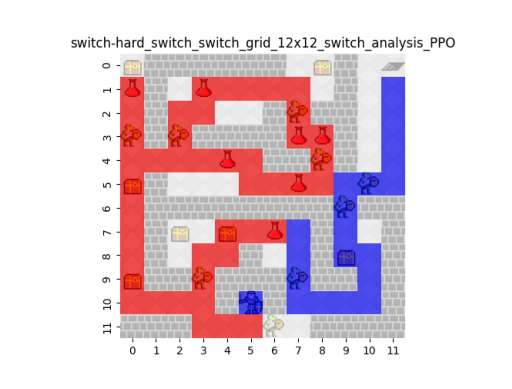

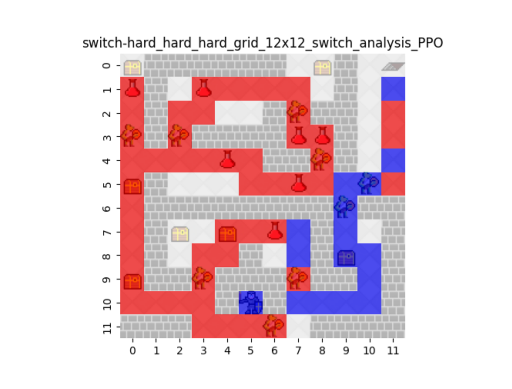

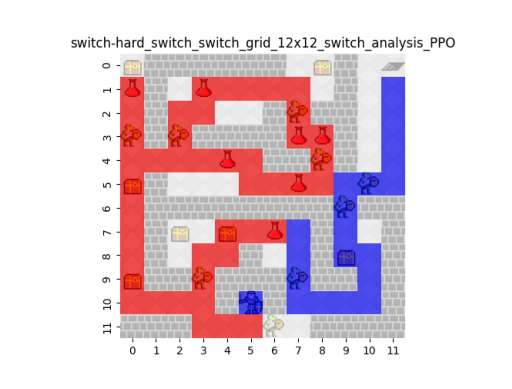

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_switch_switch_grid_12x12_switch_analysis_PPO
action
POTION    581
RUNNER    199
Name: count, dtype: int64
(4, 780, 12, 12)
(12, 12)
(780, 4, 12, 12)
(12, 12)


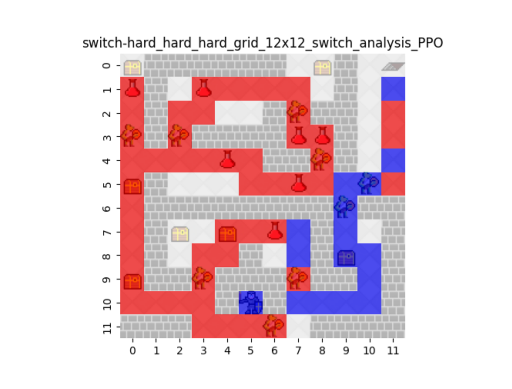

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_hard_hard_grid_12x12_switch_analysis_PPO
action
POTION    631
RUNNER    169
Name: count, dtype: int64
(4, 800, 12, 12)
(12, 12)
(800, 4, 12, 12)
(12, 12)


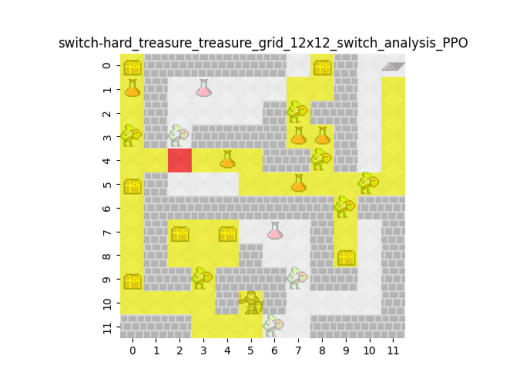

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_treasure_treasure_grid_12x12_switch_analysis_PPO
action
TREASURE    690
POTION       10
Name: count, dtype: int64
(4, 700, 12, 12)
(12, 12)
(700, 4, 12, 12)
(12, 12)


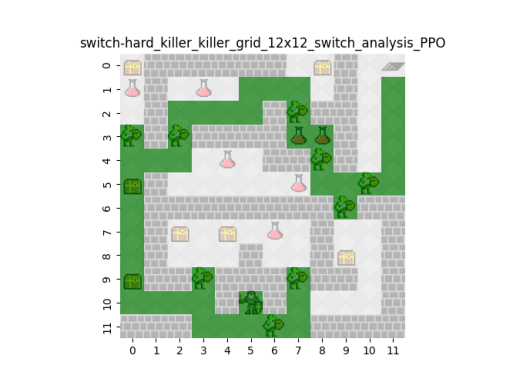

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'killer', 'reward_scheme': 'killer', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_killer_killer_grid_12x12_switch_analysis_PPO
action
KILLER    520
Name: count, dtype: int64
(4, 520, 12, 12)
(12, 12)
(520, 4, 12, 12)
(12, 12)


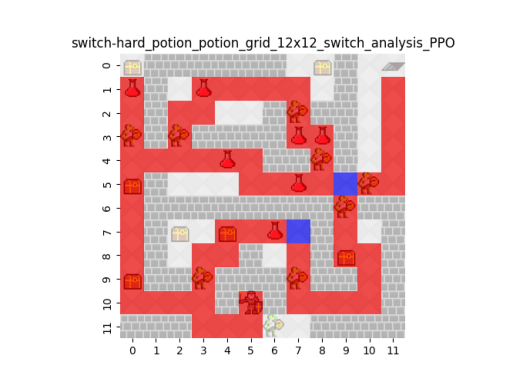

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'potion', 'reward_scheme': 'potion', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_potion_potion_grid_12x12_switch_analysis_PPO
action
POTION    760
RUNNER     20
Name: count, dtype: int64
(4, 780, 12, 12)
(12, 12)
(780, 4, 12, 12)
(12, 12)


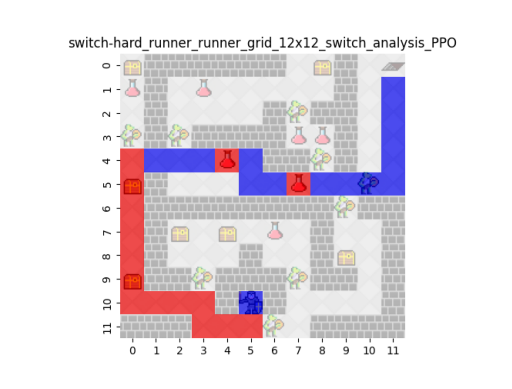

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'runner', 'reward_scheme': 'runner', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_runner_runner_grid_12x12_switch_analysis_PPO
action
POTION    151
RUNNER    149
Name: count, dtype: int64
(4, 300, 12, 12)
(12, 12)
(300, 4, 12, 12)
(12, 12)


<Figure size 640x480 with 0 Axes>

In [3]:
# configs = gen_config(lvl = 'holmgard_1', algo='PPO',obs_type='distance', switch_path='switching_analysis',  base_path='play_style_models/base/')
# print(configs[0])
# explainer, shap_vals, data, df = shappy(configs[0])
gen_analysis(analysis_loc='./test_analysis/grid/Hard_Analysis/',lvl='hard', obs_type='grid', explainer_type='deep',exp_type='grid_12x12_switch_analysis',exp_path = 'switching_grid_12x12_analysis', base_path='play_style_models/grid_base_12x12/')

In [4]:
df.head()

,experiment,level,run,step,x,y,hp,curr_grid,grid,play_style,action,curr_obs,observation,done,reward,info,grid_rows,grid_columns
0,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,0,4,11,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[4, 2, 2, 4, 4, 17, 17, 40]","[3, 1, 1, 3, 3, 16, 16, 40]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 1, '.': 1}",12,12
1,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,1,4,10,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[3, 1, 1, 3, 3, 16, 16, 40]","[4, 2, 2, 2, 2, 15, 15, 40]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 2, '.': 2}",12,12
2,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,2,5,10,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[4, 2, 2, 2, 2, 15, 15, 40]","[5, 3, 3, 1, 1, 14, 14, 40]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 3, '.': 3}",12,12
3,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,3,6,10,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[5, 3, 3, 1, 1, 14, 14, 40]","[5, 4, 4, 0, 0, 13, 13, 50]",False,-2.0,"{'action_taken': 'POTION', 'POTION': 4, '.': 3...",12,12
4,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,4,7,10,50,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[5, 4, 4, 0, 0, 13, 13, 50]","[4, 5, 5, 1, 1, 14, 14, 50]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 5, '.': 4...",12,12


----------------------------------------------------Generting quantitative results-------------------------------------------


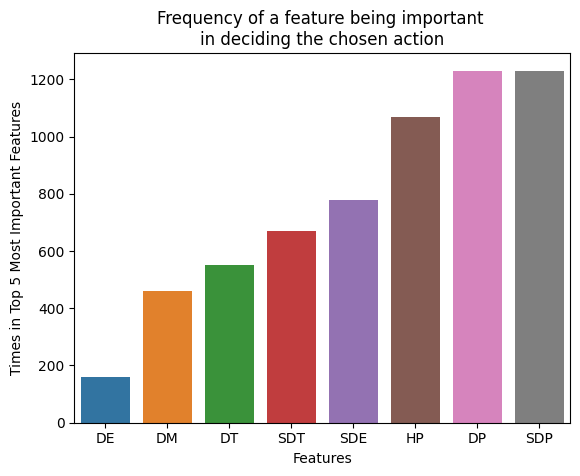

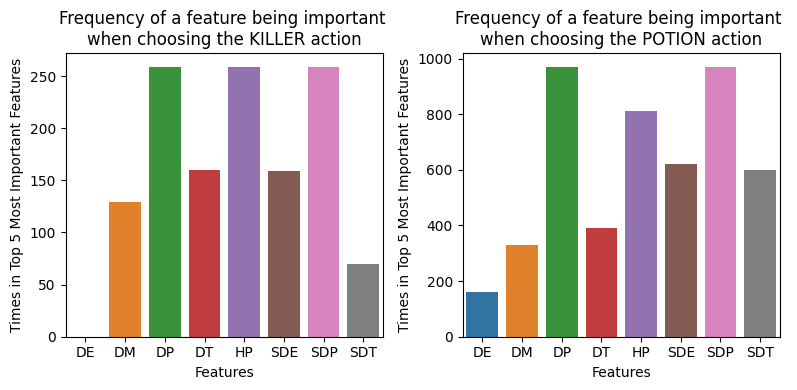

In [5]:
df_shap, df_rankings, df_action_rankings = qauntitative_results(explainer=explainer,shap_vals=shap_vals, data=data, df=df)

     Importance_count
DE              160.0
DM              459.0
DT              550.0
SDT             671.0
SDE             780.0
HP             1070.0
DP             1230.0
SDP            1230.0


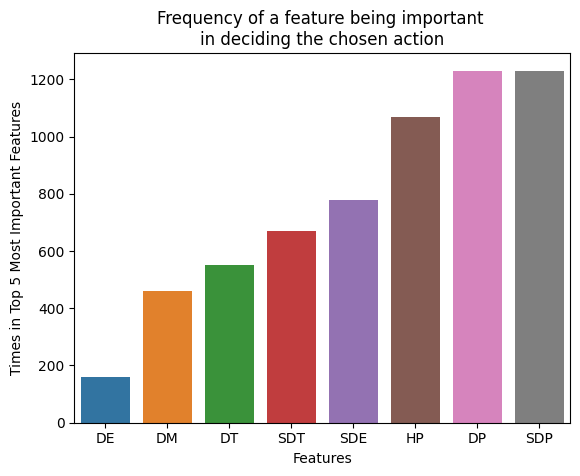

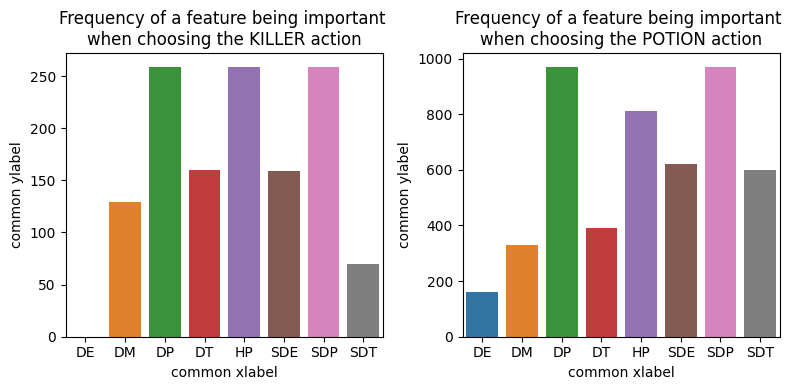

value,DE,DM,DP,DT,HP,SDE,SDP,SDT
action,,,,,,,,
KILLER,0,129,259,160,259,159,259,70
POTION,160,330,971,390,811,621,971,601


In [6]:
# create shap value df
df_shap = df[['curr_obs', 'action']]
shap_valss = []
policy_classes = ['killer','treasure','runner','potion']

#
reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
action_shap_vals=[]
#get shap_vals for chosen action
for i, row in df.iterrows():
    action = row['action']
    # get action taken index
    action_idx = policy_classes.index(action.lower())
    action_shap_vals.append(reshaped_shap_vals[i][action_idx])

# Add shap_vals to the dataframe
df_shap["shap_vals"] = pd.Series(action_shap_vals)
df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

# get the top five features for each state
df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))

# create rankings dataframe for the whole level by adding up the value counts
df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')
print(df_rankings)

def plot_frequency(ax, x, y, xlabel, ylabel, title):
    sns.barplot(x=x, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

ax = sns.barplot(x=df_rankings.index, y=df_rankings.Importance_count)
ax.set(xlabel='Features', ylabel='Times in Top 5 Most Important Features', title="Frequency of a feature being important \nin deciding the chosen action")

melted_df = pd.melt(df_shap[['action','1st','2nd','3rd','4th','5th']], id_vars=['action'], value_vars=['1st', '2nd', '3rd', '4th', '5th'])
df_action_rankings = pd.crosstab(index=melted_df['action'], columns=melted_df['value'])

fig, ax = plt.subplots(1, len(df_action_rankings), figsize=(4 * len(df_action_rankings), 4))

for i in range(len(df_action_rankings)):
    plot_frequency(ax[i], df_action_rankings.columns, df_action_rankings.iloc[i],
                   xlabel='common xlabel', ylabel='common ylabel',
                   title=f"Frequency of a feature being important \nwhen choosing the {df_action_rankings.index[i]} action")

plt.tight_layout()
plt.show()

df_action_rankings


## Grid 12x12 stuff


In [10]:
# configs = gen_config(lvl = 'hard', algo='PPO',obs_type='grid', switch_path='switching_grid_12x12_analysis',  base_path='play_style_models/grid_base_12x12/')
config_switch ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': "grid",
        'lvl': 'hard',
        'play_style': 'switch',
        'reward_scheme': 'switch',
        'exp_type': 'grid_12x12_switch_analysis',
        'learning_algo': 'PPO',
        'exp_path': 'switching_grid_12x12_analysis',
        'base_path': 'play_style_models/grid_base_12x12/',
    }
print(config_switch)
from md_shap import gen_data, sb3Wrapper, sb3_DQN_wrapper
from torch import float32
from torch.autograd import Variable

class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net

    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = self.policy_net(x)
        x = self.action_net(x)
        return x

def shappy(config,explainer_type ='deep'):
    print('----------Perfroming Shapley Analysis----------')
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']
    #generate data
    data =gen_data(config)
    df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
    print(df['action'].value_counts())
    df_to_analyse = df[df['action'].isin({f'{play_style.upper()}', f'{play_style.upper()}_SAFELY'})]
    # print(df_to_analyse[['action', 'observation']])
    # print(df[['action','observation']])
    #load PPO model
    if action_type == "switch":
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        model_path = f"logs/{path}/{exp}/{play_style}/best_model"
    else:
        exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"
        model_path = f"logs/{path}/{exp}/best_model/best_model"

    if algo =="PPO":
        model = PPO.load(model_path, device='cuda')
    elif algo =='DQN':
        model = DQN.load(model_path, device='cuda')
    state_log = np.array(df['curr_obs'].values.tolist())
    data =torch.FloatTensor(state_log).to('cuda')
    print(data.shape)
    # print(model.policy)
    # print(model.policy.q_net.q_net)
    # print(model.policy.feature)
    if algo =='PPO':
        model = sb3Wrapper(model)
    elif algo == 'DQN':
        model = sb3_DQN_wrapper(model)
    

    if explainer_type == "kernel":
        f = lambda x: model.forward(Variable(torch.from_numpy(x)).to(float32).cuda()).detach().cpu().numpy()
        explainer = shap.KernelExplainer(f, state_log)
        shap_vals= explainer.shap_values(state_log)
    else:
        explainer = shap.DeepExplainer(model, data)
        shap_vals= explainer.shap_values(data,check_additivity=True)

    # explainer=shap.Explainer(model.forward,data)
    # shap_vals= explainer.shap_values(state_log)
    # return
    return explainer, shap_vals, data, df


explainer, shap_vals, data, df = shappy(config_switch)

{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_switch_switch_grid_12x12_switch_analysis_PPO
action
POTION    581
RUNNER    199
Name: count, dtype: int64
torch.Size([780, 12, 12])


In [22]:
from md_shap import state_image,convert_fig, make_state_gif
from PIL import Image
import cv2
import imageio
import os

# configs = gen_config(lvl = 'holmgard_1', algo='PPO',obs_type='distance', switch_path='switching_analysis',  base_path='play_style_models/base/')
# print(configs[0])
# explainer, shap_vals, data, df = shappy(configs[0])
# print(np.array(shap_vals).shape)
# print(shap_vals[0][0])
def gen_grid_shap(shap_vals,df, save_loc):
    policy_classes = ['killer','treasure','runner','potion']
    state_loc = f"{save_loc}state_shap_images/"
    os.makedirs(state_loc,exist_ok=True)  
    shap_vals = np.array(shap_vals)
    print(shap_vals.shape)
    print(shap_vals[0][0].shape)
    reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2,3))
    print(reshaped_shap_vals.shape)
    print(reshaped_shap_vals[0][0].shape)
    df_shap = df[['run','x','y','hp','curr_obs', 'action']]
    # print(sha)
    action_shap_vals=[]
    #get shap_vals for chosen action
    for i, row in df.iterrows():
        action = row['action']
        # get action taken index
        action_idx = policy_classes.index(action.lower())
        action_shap_vals.append(reshaped_shap_vals[i][action_idx])

    # Add shap_vals to the dataframe
    df_shap["shap_vals"] = pd.Series(action_shap_vals)
    images =[]
    temp =df_shap[(df_shap['run']==0)]
    temp
    for i, row in df_shap[(df_shap['run']==0)].iterrows():
        # print(row.shap_vals.shape)
        # newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')
        heat =sns.heatmap(row.shap_vals,cmap='bwr',alpha= 0.6,zorder=2, center=0.0)
        # gen state image
        state = state_image(row['curr_obs'],row['x'],row['y'],row['hp'])
        # state = state_image(df_shap['curr_obs'].iloc[0],df['x'].iloc[0],df['y'].iloc[0],df['hp'].iloc[0])
        # state = cv2.cvtColor(state, cv2.COLOR_BGR2RGB)
        img = heat.imshow(state,aspect=heat.get_aspect(),extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
        plt.title(f"Action: {row['action']}")
        img = convert_fig(plt)
        images.append(img)
        Image.fromarray(img).save(f'{state_loc}state{i}.png')

        # cv2.imwrite(f'/gifs/state_images/state{i}.png',img)
        plt.clf()

    # images[0].save(f"{state_loc}.pdf", save_all = True, append_images= images[1:])

    # make_state_gif(images, './gifs/AAA.gif')
    # images[0].save("/gifs/array.gif", save_all=True, append_images=img[1:], duration=50, loop=0)
    imageio.mimsave(f'{state_loc}State_Shap_Gif.gif', images,duration=1000)
    imageio.mimsave(f'{state_loc}State_shap.pdf', images)


gen_grid_shap(shap_vals=shap_vals,df=df,save_loc='./test_analysis/kernel/')
# print(len(images))

(4, 780, 12, 12)
(12, 12)
(780, 4, 12, 12)
(12, 12)


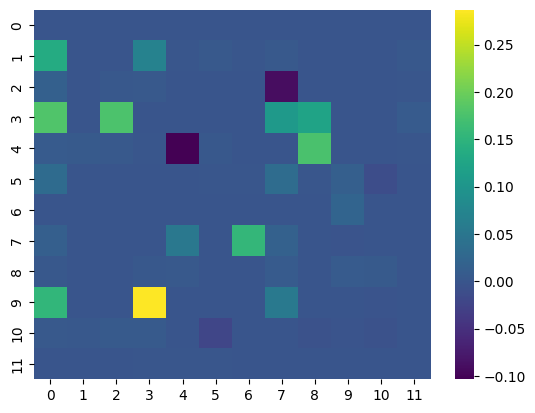

In [141]:
sns.heatmap(reshaped_shap_vals[0][-1],cmap='viridis')
import shap
def gen_heatmap(df,f):
    df = df.reset_index()
    x_array = df['x'].to_numpy()
    y_array =df['y'].to_numpy()
    grid = np.zeros((df['grid_rows'][0],df['grid_columns'][0]))
    for i, j in zip(y_array,x_array):
        grid[i,j]+=1
    heat =sns.heatmap(grid,cmap='viridis',alpha =0.4,zorder=2, cbar = False)
    my_image = cv2.imread(f)
    my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
    # plt.imshow(my_image)
    plt.title(df['experiment'][0])
    # print(heat.get_aspect())
    img = heat.imshow(my_image,extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
    # img = convert_fig(plt)
    plt.clf()
    return img



In [120]:
print(reshaped_shap_vals[0][0])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.49955538e-02  0.00000000e+00  0.00000000e+00 -2.09637601e-02
  -2.83726695e-04 -1.55455468e-03 -5.50014258e-04 -1.75702514e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.49742991e-03]
 [-4.24832618e-03  0.00000000e+00 -9.28505789e-04 -1.24583824e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.98908965e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.03422673e-03]
 [-4.13406827e-02  0.00000000e+00 -4.93541136e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.60427445e-02
  -2.44637225e-02  0.00000000e+00  0.00000000e+00 -1.88381691e-03]
 [-3.58888577e-03 -1.24583067e-03 -1.89840689e-03 -6.32103300e-04
   2.62027662e-02 -1.40355248e-03  0.00000000e+00  0.00000000e+00
  -5.86012192e-02  0.00000000e+00  0.00000000e+00 -1.80663448e-03]
 [-7.